In [24]:
# changing working directory (Google colab)
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/ML/TrojanGuard/code

ModuleNotFoundError: No module named 'google'

In [ ]:
# for saving changes to github (Google colab)
%cd ..
!git config --global user.email  "abdosalm555@gmail.com"
!git config --global user.name "abdosalem490"
!git add .
!git commit -am "[UPDATE]: added google colab cells"
!git push
%cd code

/
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
[Errno 2] No such file or directory: 'code'
/


In [117]:
# add the needed imports
from lazypredict.Supervised import LazyClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
import pickle
import sys
import copy
import math
import time
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps

In [118]:
# read the dataset
df = pd.read_csv("Trojan_Detection_dataset.csv")

# remove leading and trailing whitespaces from column names
df = df.rename(columns=lambda x: x.strip())

# list of protocol name where every index represents the protocol number
# protocol_names = ["HOPOPT", "ICMP", "IGMP", "GGP", "IPv4", "ST", "TCP", "CBT", "EGP", "IGP", "BBN-RCC-MON", "NVP-II", "PUP", "ARGUS (deprecated)", "EMCON", "XNET", "CHAOS", "UDP"]

# column_descriptions = {
#     "record_id": "represents the id of the record",
#     "Flow ID": "written as <source/destination ip> - <source/destination ip> - <destination/source port> - <destination/source port> - <protocol>.",
#     "Source IP": "IP address of source",
#     "Source Port": "Port number of source",
#     "Destination IP": "IP address of destination",
#     "Destination Port": "Port number of destination",
#     "Protocol": "name protocol used, refer to @protocol_names list",
#     "Timestamp": "digital record of the date and time when the frame transmitted",
#     "Flow Duration": "the time elapsed between receiving the first and last packets in the flow",
#     "Total Fwd Packets": ""
# }

USE_LABEL_ENCODER = True


# remove Timestamp, Flow ID, Class and record_id columns
global_labels = df['Class']
df = df.drop(columns=['Timestamp', 'Flow ID', 'Class', 'record_id'])

# drop columns not specified to the problem
# df = df.drop(columns=['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol'])

# split the dataset into 75% training, 25% testing
X_train, X_test, Y_train, Y_test = train_test_split(df, global_labels, test_size=0.25, random_state=121, shuffle=True, stratify=global_labels)
# Note: stratify keeps the proportion of labels same for the result train and test data


# reset the indexes of the data after splitting as the data keeps its original index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

# make a copy of the training data so that to be compared with the results after modification
X_training_unModified = copy.deepcopy(X_train)
Y_training_unModified = copy.deepcopy(Y_train)
X_testing_unModified = copy.deepcopy(X_test)
Y_testing_unModified = copy.deepcopy(Y_test)


In [119]:
# Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.
X_train.describe()
# df["Flow Duration"].describe()

Source Port  Destination Port  Protocol  Flow Duration  \
count    133111.00         133111.00 133111.00      133111.00   
mean      38677.25           5728.70      8.29    11627116.90   
std       18396.81          15112.31      4.54    23012414.79   
min           0.00              0.00      0.00           2.00   
25%       34210.00             80.00      6.00       47124.50   
50%       43105.00            443.00      6.00      489011.00   
75%       52145.00            443.00      6.00    10621120.00   
max       65530.00          64872.00     17.00   119999100.00   

       Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
count          133111.00               133111.00                    133111.00   
mean                6.76                    9.82                       812.06   
std                30.88                  108.27                      5990.73   
min                 1.00                    0.00                         0.00   
25%                 1.00                    0.00                         0.00   
50%                 2.00                    1.00                        31.00   
75%                 5.00                    4.00                       456.00   
max              4502.00                12951.00                    846614.00   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
count                    133111.00              133111.00   
mean                      10099.82                 230.86   
std                      154521.47                 392.28   
min                           0.00                   0.00   
25%                           0.00                   0.00   
50%                          31.00                  31.00   
75%                         495.00                 360.00   
max                    18684972.00                1460.00   

       Fwd Packet Length Min  ...  act_data_pkt_fwd  min_seg_size_forward  \
count              133111.00  ...         133111.00             133111.00   
mean                   13.43  ...              1.68                 27.80   
std                    68.89  ...              6.89                  6.66   
min                     0.00  ...              0.00                 -1.00   
25%                     0.00  ...              0.00                 20.00   
50%                     0.00  ...              0.00                 32.00   
75%                    19.00  ...              1.00                 32.00   
max                  1460.00  ...            586.00                 60.00   

       Active Mean  Active Std  Active Max  Active Min    Idle Mean  \
count    133111.00   133111.00   133111.00   133111.00    133111.00   
mean     142253.96    20455.36   161871.32   126604.05   4527301.58   
std      784640.82   247120.01   880394.66   756249.31  15417940.75   
min           0.00        0.00        0.00        0.00         0.00   
25%           0.00        0.00        0.00        0.00         0.00   
50%           0.00        0.00        0.00        0.00         0.00   
75%           0.00        0.00        0.00        0.00         0.00   
max    30594213.00 15999508.03 30594213.00 30594213.00 119773643.00   

         Idle Std     Idle Max     Idle Min  
count   133111.00    133111.00    133111.00  
mean    396093.59   4876552.46   4225439.01  
std    3209320.84  16253085.52  15043254.66  
min          0.00         0.00         0.00  
25%          0.00         0.00         0.00  
50%          0.00         0.00         0.00  
75%          0.00         0.00         0.00  
max   74451824.53 119773643.00 119773643.00  

[8 rows x 80 columns]

In [120]:
# prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133111 entries, 0 to 133110
Data columns (total 82 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Source IP                    133111 non-null  object 
 1   Source Port                  133111 non-null  int64  
 2   Destination IP               133111 non-null  object 
 3   Destination Port             133111 non-null  int64  
 4   Protocol                     133111 non-null  int64  
 5   Flow Duration                133111 non-null  int64  
 6   Total Fwd Packets            133111 non-null  int64  
 7   Total Backward Packets       133111 non-null  int64  
 8   Total Length of Fwd Packets  133111 non-null  int64  
 9   Total Length of Bwd Packets  133111 non-null  int64  
 10  Fwd Packet Length Max        133111 non-null  int64  
 11  Fwd Packet Length Min        133111 non-null  int64  
 12  Fwd Packet Length Mean       133111 non-null  float64
 13 

In [121]:
X_train.head(10).T

0               1           2               3  \
Source IP             10.42.0.42      10.42.0.42  10.42.0.42      10.42.0.42   
Source Port                48983           34014        1976           60140   
Destination IP    123.125.29.220  172.217.12.202   10.42.0.1  202.77.129.161   
Destination Port              80             443          53              80   
Protocol                       6               6          17               6   
...                          ...             ...         ...             ...   
Active Min                     0         1955451           0               0   
Idle Mean                   0.00     58576706.00        0.00            0.00   
Idle Std                    0.00            0.00        0.00            0.00   
Idle Max                       0        58576706           0               0   
Idle Min                       0        58576706           0               0   

                               4               5           6              7  \
Source IP            10.42.0.211      10.42.0.42  10.42.0.42     10.42.0.42   
Source Port                57976           57903       60833          44359   
Destination IP    216.58.219.227  63.250.200.101   10.42.0.1  174.35.73.148   
Destination Port             443             443          53             80   
Protocol                       6               6          17              6   
...                          ...             ...         ...            ...   
Active Min                241715               0           0              0   
Idle Mean            14201349.00            0.00        0.00           0.00   
Idle Std                    0.00            0.00        0.00           0.00   
Idle Max                14201349               0           0              0   
Idle Min                14201349               0           0              0   

                               8           9  
Source IP             10.42.0.42  10.42.0.42  
Source Port                34505       22638  
Destination IP    202.77.129.150   10.42.0.1  
Destination Port              80          53  
Protocol                       6          17  
...                          ...         ...  
Active Min                     0           0  
Idle Mean                   0.00        0.00  
Idle Std                    0.00        0.00  
Idle Max                       0           0  
Idle Min                       0           0  

[82 rows x 10 columns]

<Figure size 640x480 with 0 Axes>

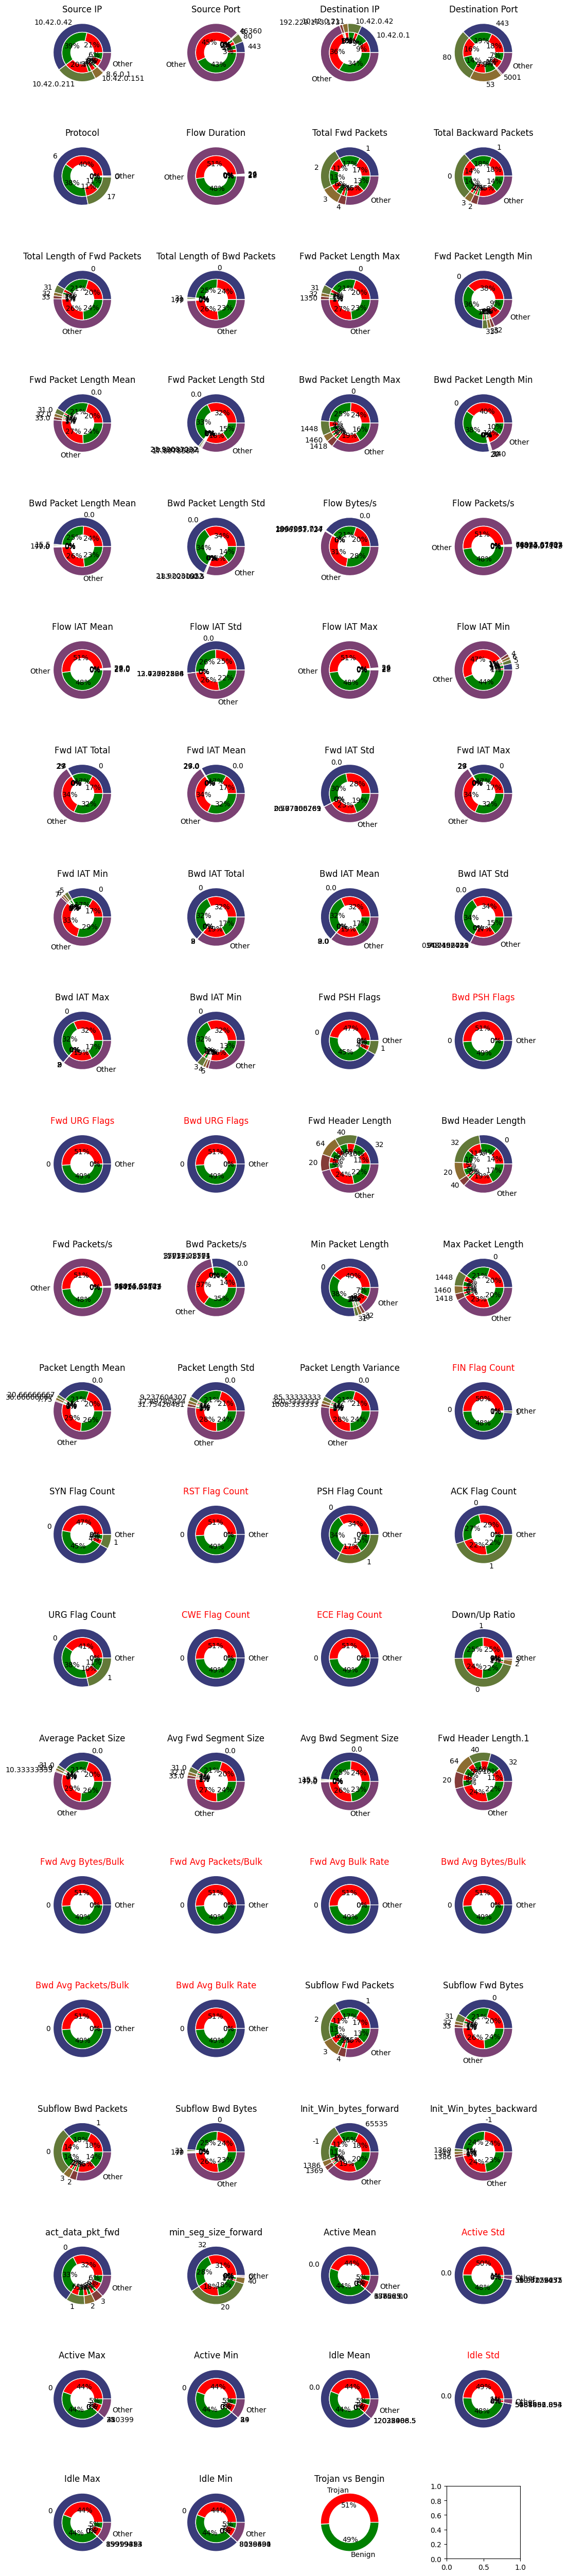

In [122]:
# get the total number of Trojan and benign classes from training data
Trojan_total = Y_train.value_counts().iloc[0]
Benign_total = Y_train.value_counts().iloc[1]

# store in it the indexes of the columns that represents the features that aren't important (15 features)
indexes_of_columns_to_dropped = [35, 36, 37, 47, 49, 53, 54, 60, 61, 62, 63, 64, 65, 75, 79]

# visualize features in pie chart manner
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(21, 4, figsize=(10,50))
fig.tight_layout(h_pad=5, w_pad=5)

j = 0
for series_name, series in X_train.items():

#     print(f"{j//4}, {j%4}, {series_name}")

    # to handle the case when the number of unique values are less than 5
    largest_n_num = 4
    if len(series.value_counts()) <= largest_n_num:
        largest_n_num = len(series.value_counts())

    # get the largest IP addresses (default = 4)
    largest_4 = series.value_counts().nlargest(largest_n_num)
    # add fifth element which represents the other IP address
    largest_4.loc['Other'] = len(series)-sum(largest_4.values)

    # plot 4 biggest values for each feature and how much every class resemble this feature
    cmap = plt.colormaps["tab20b"]
    outer_colors = cmap(np.arange(5)*4)
    inner_colors = cmap([1, 2, 5, 6, 9, 10, 14, 15, 18, 19])

    # count number of Trojans and Benigns for each value of the current feature
    vals = []
    Trojan_list = []
    Benign_list = []

    for i in range(0, largest_n_num):
        torjan_c = len(X_train.loc[(series==largest_4.index[i]) & (Y_train=="Trojan")])
        benign_c = len(X_train.loc[(series==largest_4.index[i]) & (Y_train=="Benign")])
        Trojan_list.append(torjan_c)
        Benign_list.append(benign_c)
        vals.append(torjan_c)
        vals.append(benign_c)


    # add the value for the others
    others_trojan = Trojan_total-sum(Trojan_list)
    others_benign = Benign_total-sum(Benign_list)
    vals.append(others_trojan)
    vals.append(others_benign)

    colour = "black"
    if j in indexes_of_columns_to_dropped: # indexes of features to be neglected
        colour = "red"
    
    ax[j//4][j%4].set_title(series_name, color=colour)
    ax[j//4][j%4].pie(largest_4.values, labels=largest_4.index, radius=1, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

    # green is not trojan, red is trojan
    ax[j//4][j%4].pie(vals, radius=0.7, colors=["red", "green"],
           wedgeprops=dict(width=0.3, edgecolor='w'), autopct='%1.0f%%')

    # move to the next cell
    j += 1

# plot number of benign against trojan
ax[j//4][j%4].set_title("Trojan vs Bengin")
ax[j//4][j%4].pie(Y_train.value_counts().values, labels=Y_train.value_counts().index, radius=1, colors=["red", "green"],
       wedgeprops=dict(width=0.3, edgecolor='w'), autopct='%1.0f%%')

plt.show()



In [123]:
# thus said we need to remove the highlighted features above as the feature is having a constant value nearly distributed equally between the 2 classes, so it's not important (can be neglected)
X_train.drop(X_train.columns[indexes_of_columns_to_dropped], axis=1, inplace=True)

X_train

Source IP  Source Port  Destination IP  Destination Port  \
0          10.42.0.42        48983  123.125.29.220                80   
1          10.42.0.42        34014  172.217.12.202               443   
2          10.42.0.42         1976       10.42.0.1                53   
3          10.42.0.42        60140  202.77.129.161                80   
4         10.42.0.211        57976  216.58.219.227               443   
...               ...          ...             ...               ...   
133106    10.42.0.211        35144   209.10.120.26                80   
133107     10.42.0.42        55255  123.59.190.237                80   
133108     10.42.0.42        47678  104.244.43.227               443   
133109     10.42.0.42        58449   172.217.11.14               443   
133110  77.234.44.201           80      10.42.0.42             52734   

        Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              6         290032                  1                       1   
1              6       60631432                 88                      98   
2             17        1172343                  1                       1   
3              6       30484454                  2                       2   
4              6       14443064                  9                       7   
...          ...            ...                ...                     ...   
133106         6         106297                  3                       2   
133107         6       10487111                  3                       1   
133108         6       96563064                  3                       0   
133109         6       98486799                 11                      10   
133110         6           2196                  1                       1   

        Total Length of Fwd Packets  Total Length of Bwd Packets  ...  \
0                                 0                            0  ...   
1                              4826                       127271  ...   
2                                33                          153  ...   
3                                 0                          106  ...   
4                               504                         4755  ...   
...                             ...                          ...  ...   
133106                          342                          174  ...   
133107                            0                            0  ...   
133108                            0                            0  ...   
133109                         1260                         5048  ...   
133110                            0                            0  ...   

        Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  \
0                         1386                      137                 0   
1                        65535                      439                 7   
2                           -1                       -1                 0   
3                        65535                      115                 0   
4                        65535                      349                 2   
...                        ...                      ...               ...   
133106                   65535                      512                 1   
133107                   65535                     8190                 0   
133108                    1731                       -1                 0   
133109                   65535                      362                 4   
133110                       1                     1386                 0   

        min_seg_size_forward  Active Mean  Active Max  Active Min   Idle Mean  \
0                         20         0.00           0           0        0.00   
1                         32   1955451.00     1955451     1955451 58576706.00   
2                         20         0.00           0           0        0.00   
3                         20         0.00           0           0        0.00   
4  

In [124]:
# convert IP address into a number from the format(A.B.C.D) to (AAABBBCCCDDD)
def convertIP(IP_addr):
    IP_list = [int(x) for x in IP_addr.split(".")]
    IP_num = sum([x * (10**(3*(3-i))) for i, x in enumerate(IP_list)])
    return IP_num


source_ip_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-5000)
destination_ip_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-5000)

# apply the conversion
if USE_LABEL_ENCODER:
    source_ip_encoder.fit(X_train['Source IP'].values.reshape(-1, 1))
    destination_ip_encoder.fit(X_train['Destination IP'].values.reshape(-1, 1))

    X_train['Source IP'] = source_ip_encoder.transform(X_train['Source IP'].values.reshape(-1, 1)).flatten()
    X_train['Destination IP'] = destination_ip_encoder.transform(X_train['Destination IP'].values.reshape(-1, 1)).flatten()

    X_training_unModified['Source IP'] = source_ip_encoder.transform(X_training_unModified['Source IP'].values.reshape(-1, 1)).flatten()
    X_training_unModified['Destination IP'] = destination_ip_encoder.transform(X_training_unModified['Destination IP'].values.reshape(-1, 1)).flatten()

else:
    X_train['Source IP'] = X_train['Source IP'].apply(convertIP)
    X_train['Destination IP'] = X_train['Destination IP'].apply(convertIP)

    X_training_unModified['Source IP'] = X_training_unModified['Source IP'].apply(convertIP)
    X_training_unModified['Destination IP'] = X_training_unModified['Destination IP'].apply(convertIP)

X_train.head(5)

Source IP  Source Port  Destination IP  Destination Port  Protocol  \
0       7.00        48983          353.00                80         6   
1       7.00        34014          813.00               443         6   
2       7.00         1976            7.00                53        17   
3       7.00        60140         1276.00                80         6   
4       6.00        57976         1417.00               443         6   

   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         290032                  1                       1   
1       60631432                 88                      98   
2        1172343                  1                       1   
3       30484454                  2                       2   
4       14443064                  9                       7   

   Total Length of Fwd Packets  Total Length of Bwd Packets  ...  \
0                            0                            0  ...   
1                         4826                       127271  ...   
2                           33                          153  ...   
3                            0                          106  ...   
4                          504                         4755  ...   

   Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  \
0                    1386                      137                 0   
1                   65535                      439                 7   
2                      -1                       -1                 0   
3                   65535                      115                 0   
4                   65535                      349                 2   

   min_seg_size_forward  Active Mean  Active Max  Active Min   Idle Mean  \
0                    20         0.00           0           0        0.00   
1                    32   1955451.00     1955451     1955451 58576706.00   
2                    20         0.00           0           0        0.00   
3                    20         0.00           0           0        0.00   
4                    32    241715.00      241715      241715 14201349.00   

   Idle Max  Idle Min  
0         0         0  
1  58576706  58576706  
2         0         0  
3         0         0  
4  14201349  14201349  

[5 rows x 67 columns]

In [125]:
# create an array whose size is same as the length of the data
voting = np.zeros(len(X_train), dtype=np.int32)

In [126]:
# the outliers in 'Protocol', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port' 
columns_not_to_be_outliers = ['Protocol', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port']

<Figure size 640x480 with 0 Axes>

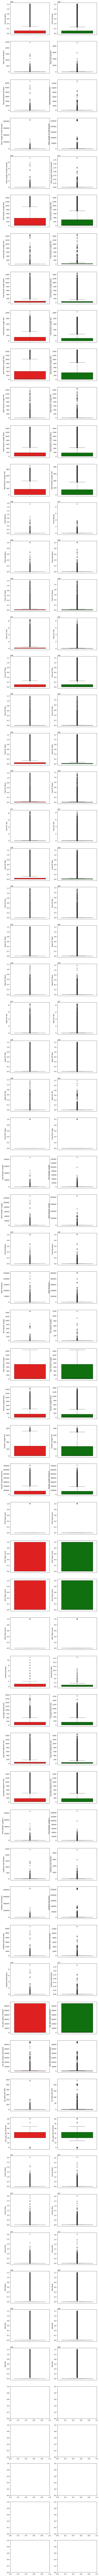

[ 2 38  4 ...  8 40  5]


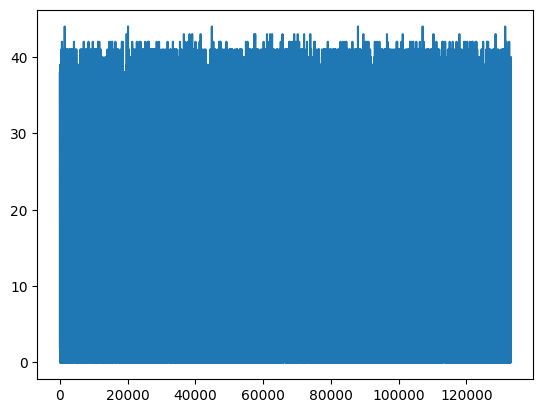

In [127]:
# apply box-plot to the features to get the IQR and vote for which points to be removed

# separate the trojan and the benign data
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(82 - len(indexes_of_columns_to_dropped), 2, figsize=(10,300))

i = 0
for series_name, series in Trojan_data.items():

  if series_name not in columns_not_to_be_outliers:
    # we chose the number of bins=30 because the default value "auto (creating number of bins equal to number of unique values)" was taking too much time (61 minute for plotting only 18 feature)
    sns.boxplot(Trojan_data[series_name], ax=ax[i][0], color="red")
    sns.boxplot(Benign_data[series_name], ax=ax[i][1], color="green")
    print(f"processing feature number {i}", end = "\r")
    i += 1

    # get the Q1 and Q3 quantiles for Trojan
    Q1 = Trojan_data[series_name].quantile(0.25)
    Q3 = Trojan_data[series_name].quantile(0.75)
    IQR = Q3 - Q1

    # get which points to be removed and vote for it 
    outliers = (Trojan_data[series_name] < Q1 - IQR) | (Trojan_data[series_name] > Q3 + IQR)

    # vote for it if it's True
    for index, value in outliers.items():
      if value:
        voting[index] += 1


    # get the Q1 and Q3 quantiles for Benign
    Q1 = Benign_data[series_name].quantile(0.25)
    Q3 = Benign_data[series_name].quantile(0.75)
    IQR = Q3 - Q1

    # get which points to be removed and vote for it 
    outliers = (Benign_data[series_name] < Q1 - IQR) | (Benign_data[series_name] > Q3 + IQR)

    # vote for it if it's True
    for index, value in outliers.items():
      if value:
        voting[index] += 1


plt.show()


plt.plot(voting)
print(voting)


<Figure size 640x480 with 0 Axes>

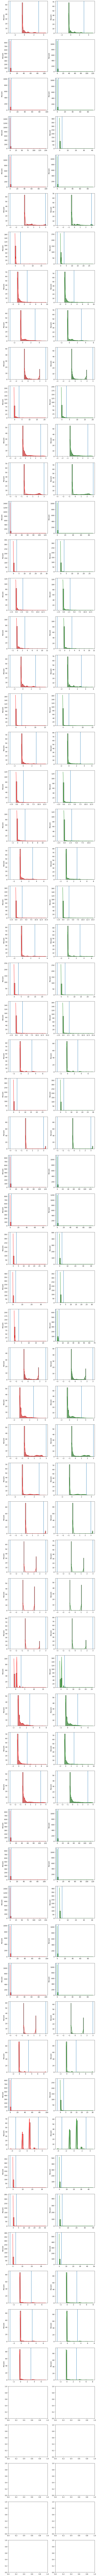

[10 40  4 ...  8 40  5]


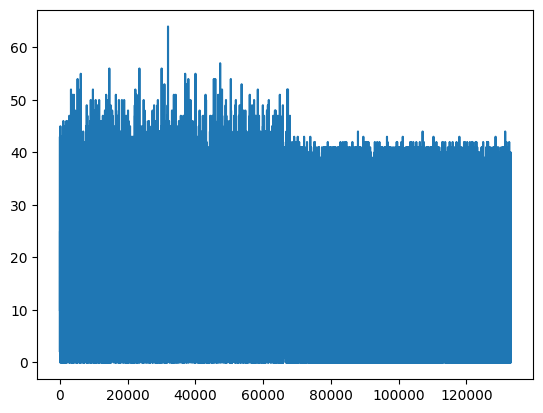

In [128]:
# apply standard scalar whose equation is "(x - mean) / std" and check for Z-score where if any point has the value < -3 or > 3 then we will vote for it

# separate the trojan and the benign data
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]


plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(82 - len(indexes_of_columns_to_dropped), 2, figsize=(10,300))


threshold = 3
i = 0
for series_name, series in Trojan_data.items():

  if series_name not in columns_not_to_be_outliers:

    # apply standard-scalar on each feature before plotting
    Trojan_normalized = StandardScaler().fit_transform(Trojan_data[series_name].values.reshape(-1, 1)).reshape(-1)
    Benign_normalized = StandardScaler().fit_transform(Benign_data[series_name].values.reshape(-1, 1)).reshape(-1)

    # get which points to be removed and vote for it (Trojan)
    outliers = (Trojan_normalized < -threshold) | (Trojan_normalized > threshold)

    # vote for it if it's True
    for index in np.where(outliers == True):
        voting[index] += 1

    # get which points to be removed and vote for it (Benign)
    outliers = (Benign_normalized < -threshold) | (Benign_normalized > threshold)

    # vote for it if it's True
    for index in np.where(outliers == True):
        voting[index] += 1
      

    # we chose the number of bins=30 because the default value "auto (creating number of bins equal to number of unique values)" was taking too much time (61 minute for plotting only 18 feature)
    sns.histplot(Trojan_normalized, stat="percent", kde=True, ax=ax[i][0], bins=30, color="red")
    sns.histplot(Benign_normalized, stat="percent", kde=True, ax=ax[i][1], bins=30, color="green")

    # plot the lines before which we will vote for the points to be outlier
    ax[i][0].axvline(x=-threshold)
    ax[i][1].axvline(x=-threshold)

    # plot the lines after which we will vote for the points to be outlier
    ax[i][0].axvline(x=threshold)
    ax[i][1].axvline(x=threshold)

    print(f"processing feature number {i}", end = "\r")
    i += 1


plt.show()



plt.plot(voting)
print(voting)

number of points in 1st cluster = 133111
number of points in 2nd cluster = 133111
percentage of cluster 2 to cluster 1 = 1.0


<Figure size 640x480 with 0 Axes>

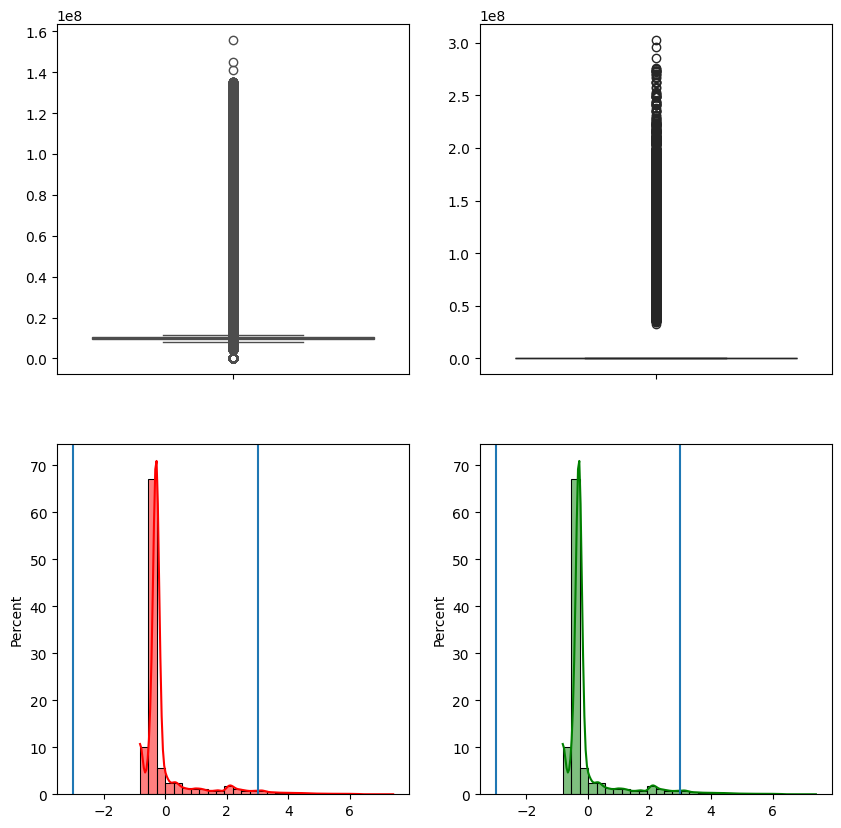

[ 43 106  37 ... 107 139  38]


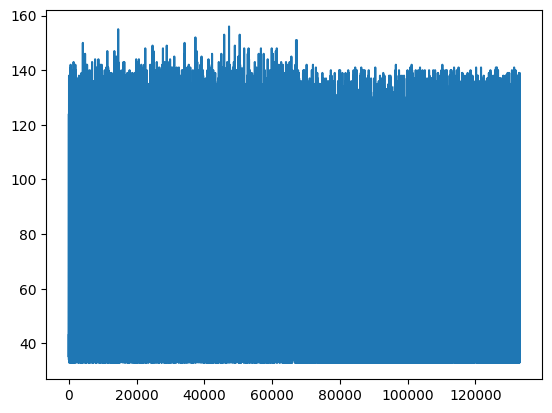

In [133]:
# using Kmeans to visualize and decided which point to remove it given its distance from the center
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_train.values)
distances = kmeans.transform(X_train.values)

# extract the distances for each near cluster alone
distances_clusters = [[], []]
distances_clusters[0] = np.zeros(len(voting))
distances_clusters[1] = np.zeros(len(voting))

for i in range(0, len(kmeans.labels_)):
    label = kmeans.labels_[i]
    distances_clusters[label][i] = distances[i][label]

# plot distances for the 2 classes each on a graph
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(2, 2, figsize=(10,10))


# plot for IQR range
sns.boxplot(distances_clusters[0], ax=ax[0][0], color="red")
sns.boxplot(distances_clusters[1], ax=ax[0][1], color="green")

# compute quantiles
Q1 = np.quantile(distances_clusters[0], 0.25)
Q3 = np.quantile(distances_clusters[0], 0.75)
IQR = Q3 - Q1

# get which points to be removed and vote for it 
outliers = (distances_clusters[0] < Q1 - IQR) | (distances_clusters[0] > Q3 + IQR)

# vote for it if it's True
voting[outliers] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it 
outliers = (distances_clusters[1] < Q1 - IQR) | (distances_clusters[1] > Q3 + IQR)

# vote for it if it's True
voting[outliers] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# compute Z-score
# apply standard-scalar on each feature before plotting
distances0_normalized = StandardScaler().fit_transform(np.array(distances_clusters[0]).reshape(-1, 1)).reshape(-1)
distances1_normalized = StandardScaler().fit_transform(np.array(distances_clusters[1]).reshape(-1, 1)).reshape(-1)

# get which points to be removed and vote for it (Benign)
outliers = (distances0_normalized < -threshold) | (distances0_normalized > threshold)

# vote for it if it's True
voting[outliers] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it (Benign)
outliers = (distances1_normalized < -threshold) | (distances1_normalized > threshold)

# vote for it if it's True
voting[outliers] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# plot the distribution of the distances
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][0], bins=30, color="red")
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][1], bins=30, color="green")

# plot the lines before which we will vote for the points to be outlier
ax[1][0].axvline(x=-threshold)
ax[1][1].axvline(x=-threshold)

# plot the lines after which we will vote for the points to be outlier
ax[1][0].axvline(x=threshold)
ax[1][1].axvline(x=threshold)

print(f"number of points in 1st cluster = {len(distances_clusters[0])}")
print(f"number of points in 2nd cluster = {len(distances_clusters[1])}")
print(f"percentage of cluster 2 to cluster 1 = {len(distances_clusters[1]) / len(distances_clusters[0])}")
plt.show()


plt.plot(voting)
print(voting)

number of points in 1st cluster = 68012
number of points in 2nd cluster = 65099


<Figure size 640x480 with 0 Axes>

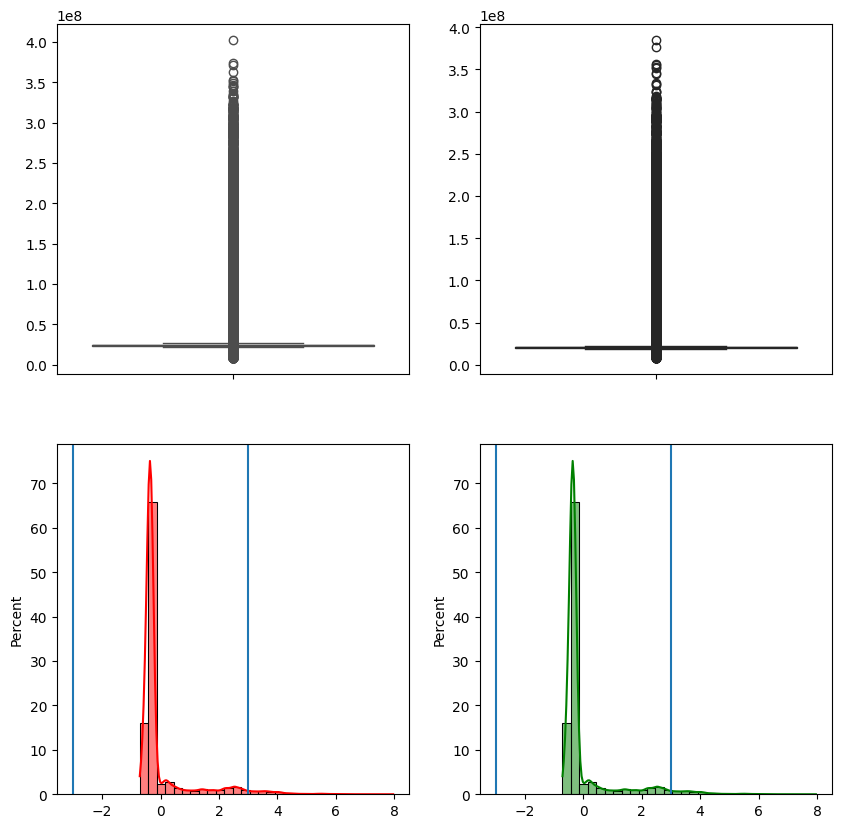

[ 76 139 103 ... 107 139  38]


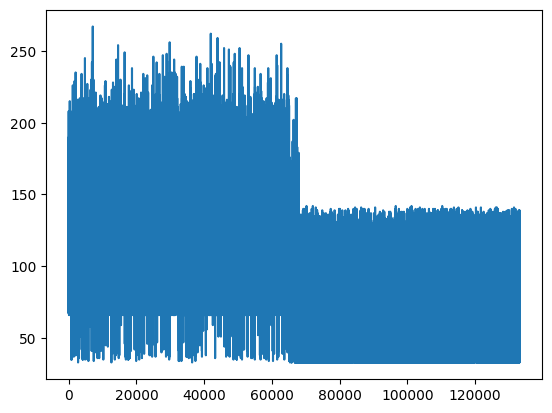

In [134]:
# separate the trojan and the benign data
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]

# find the distance between each class mean and its points
# voting = np.zeros(len(X_train), dtype=np.int32)

# calculate the mean of the data
trojan_mean = np.mean(Trojan_data, axis=0)
benign_mean = np.mean(Benign_data, axis=0)

# extract the distances for each class alone from its mean
distances_trojan = Trojan_data.apply(lambda row: math.dist(trojan_mean, row), axis=1)
distances_benign = Benign_data.apply(lambda row: math.dist(benign_mean, row), axis=1)

# plot distances for the 2 classes each on a graph
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(2, 2, figsize=(10,10))


# plot for IQR range
sns.boxplot(distances_trojan, ax=ax[0][0], color="red")
sns.boxplot(distances_benign, ax=ax[0][1], color="green")

# compute quantiles
Q1 = distances_trojan.quantile(0.25)
Q3 = distances_trojan.quantile(0.75)
IQR = Q3 - Q1

# get which points to be removed and vote for it 
outliers = (distances_trojan < Q1 - IQR) | (distances_trojan > Q3 + IQR)

# vote for it if it's True
for index in np.where(outliers==True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it 
outliers = (distances_benign < Q1 - IQR) | (distances_benign > Q3 + IQR)

# vote for it if it's True
for index in np.where(outliers==True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)


# compute Z-score
# apply standard-scalar on each feature before plotting
distances0_normalized = StandardScaler().fit_transform(distances_trojan.values.reshape(-1, 1)).reshape(-1)
distances1_normalized = StandardScaler().fit_transform(distances_benign.values.reshape(-1, 1)).reshape(-1)

# get which points to be removed and vote for it (Benign)
outliers = (distances0_normalized < -threshold) | (distances0_normalized > threshold)

# vote for it if it's True
for index in np.where(outliers == True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it (Benign)
outliers = (distances1_normalized < -threshold) | (distances1_normalized > threshold)

# vote for it if it's True
for index in np.where(outliers == True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# plot the distribution of the distances
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][0], bins=30, color="red")
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][1], bins=30, color="green")

# plot the lines before which we will vote for the points to be outlier
ax[1][0].axvline(x=-threshold)
ax[1][1].axvline(x=-threshold)

# plot the lines after which we will vote for the points to be outlier
ax[1][0].axvline(x=threshold)
ax[1][1].axvline(x=threshold)

print(f"number of points in 1st cluster = {len(distances_trojan)}")
print(f"number of points in 2nd cluster = {len(distances_benign)}")

plt.show()

plt.plot(voting)
print(voting)

<Figure size 640x480 with 0 Axes>

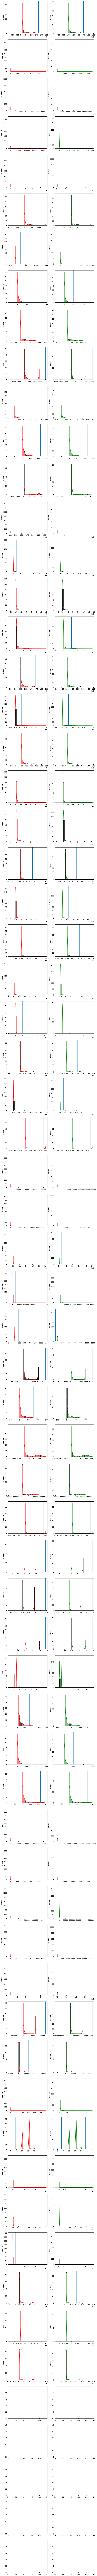

[ 84 141 103 ... 107 139  38]


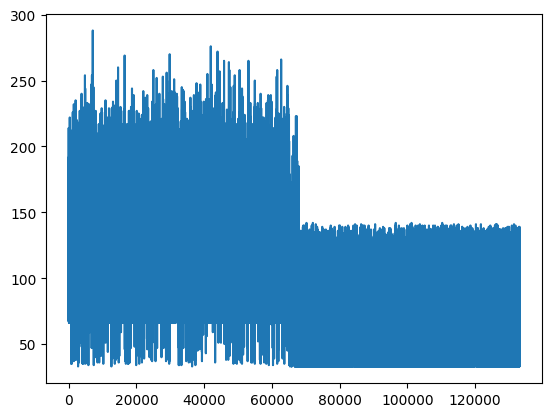

In [135]:
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]


plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(82 - len(indexes_of_columns_to_dropped), 2, figsize=(10,300))

i = 0

# vote for any point that is far from the mean of the data by threshold * standard deviation
for series_name, series in Trojan_data.items():

  if series_name not in columns_not_to_be_outliers:

    # apply standard-scalar on each feature before plotting
    #   Trojan_normalized = StandardScaler().fit_transform(Trojan_data[series_name].values.reshape(-1, 1)).reshape(-1)
    #   Benign_normalized = StandardScaler().fit_transform(Benign_data[series_name].values.reshape(-1, 1)).reshape(-1)

    # get which points to be removed and vote for it (Trojan)
    lower_bound_T = Trojan_data[series_name].mean() - threshold * Trojan_data[series_name].std()
    upper_bound_T = Trojan_data[series_name].mean() + threshold * Trojan_data[series_name].std()
    outliers = (Trojan_data[series_name] < lower_bound_T) | (Trojan_normalized > upper_bound_T)

    # vote for it if it's True
    for index in np.where(outliers == True):
        voting[index] += 1

    # get which points to be removed and vote for it (Benign)
    lower_bound_B = Benign_data[series_name].mean() - threshold * Benign_data[series_name].std()
    upper_bound_B = Benign_data[series_name].mean() + threshold * Benign_data[series_name].std()
    outliers = (Benign_data[series_name] < lower_bound_B) | (Benign_data[series_name] > upper_bound_B)

    # vote for it if it's True
    for index in np.where(outliers == True):
        voting[index] += 1
      
    # we chose the number of bins=30 because the default value "auto (creating number of bins equal to number of unique values)" was taking too much time (61 minute for plotting only 18 feature)
    sns.histplot(Trojan_data[series_name].values, stat="percent", kde=True, ax=ax[i][0], bins=30, color="red")
    sns.histplot(Benign_data[series_name].values, stat="percent", kde=True, ax=ax[i][1], bins=30, color="green")

    # plot the lines before which we will vote for the points to be outlier
    ax[i][0].axvline(x=lower_bound_T)
    ax[i][1].axvline(x=lower_bound_B)

    # plot the lines after which we will vote for the points to be outlier
    ax[i][0].axvline(x=upper_bound_T)
    ax[i][1].axvline(x=upper_bound_B)

    print(f"processing feature number {i}", end = "\r")
    i += 1


plt.show()


plt.plot(voting)
print(voting)


3818


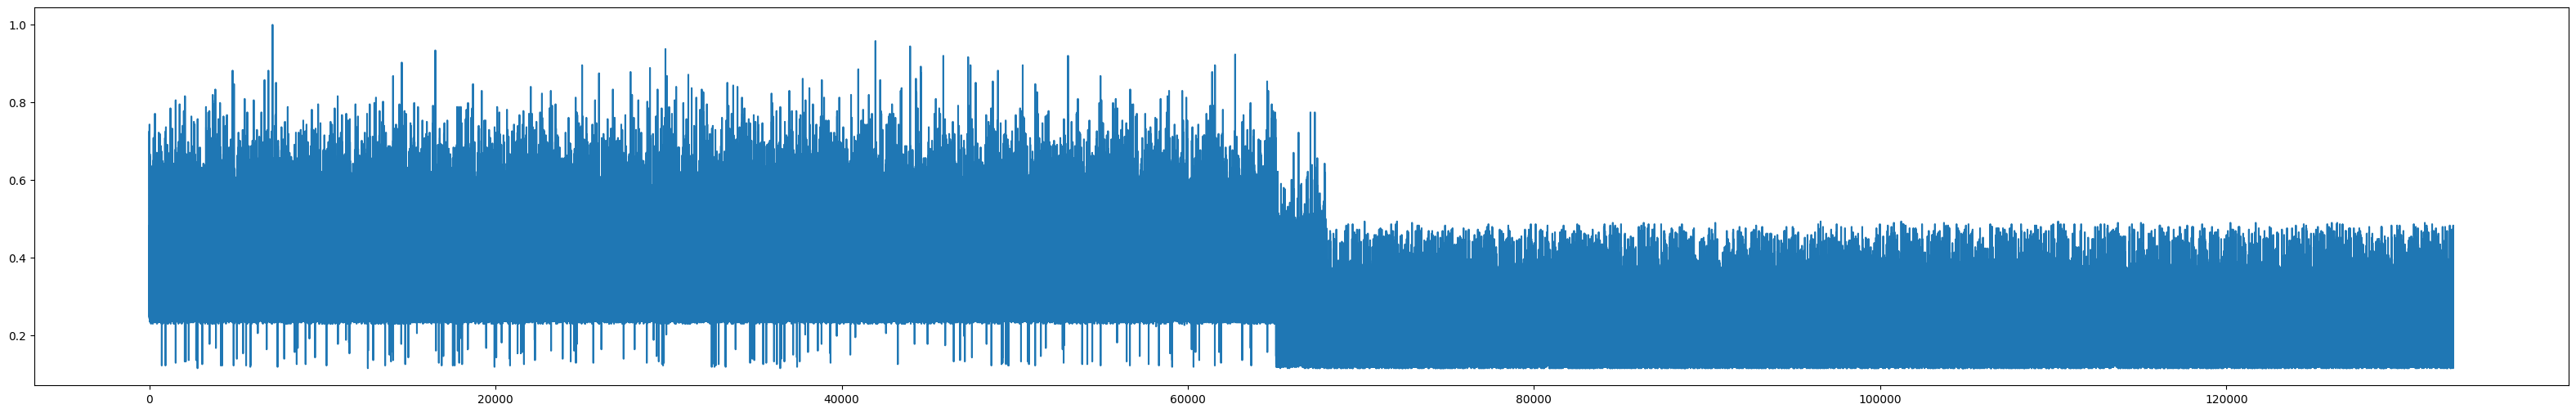

taking threshold for determining if it was an outlier or not with value 0.6 where if it's above that then it's an outlier
thus the number of points to be removed = 3818 and it's proportion of the training data = 2.8682828616718377%


In [139]:
# normalize voting
normalized_voting = voting / max(voting)

# get the indexes to be removed
outlier_threshold = 0.6
indexes_of_outliers_to_be_removed = np.where(normalized_voting >= outlier_threshold)[0]
print(len(indexes_of_outliers_to_be_removed))

# plot the voting
plt.figure(figsize=(40,6))
plt.plot(normalized_voting)
plt.show()
print(f"taking threshold for determining if it was an outlier or not with value {outlier_threshold} where if it's above that then it's an outlier")
print(f"thus the number of points to be removed = {len(indexes_of_outliers_to_be_removed)} and it's proportion of the training data = {len(indexes_of_outliers_to_be_removed) * 100 / len(X_train)}%")

# remove the points
X_train.drop(indexes_of_outliers_to_be_removed, axis=0, inplace=True)
Y_train.drop(indexes_of_outliers_to_be_removed, axis=0, inplace=True)
# we couldn't use scatter-plot as scatter-plot can't visualize data points with more than 3 features (can be extended to 5 by using color and size as extra dimension representation but still we have around 80 features)


In [17]:
# convert classes into zeros and ones for training labels
Y_train_binary_df = copy.deepcopy(Y_train)
Y_train_binary_df[Y_train_binary_df=="Trojan"] = 1
Y_train_binary_df[Y_train_binary_df=="Benign"] = 0
Y_train_binary = Y_train_binary_df.to_numpy().astype(np.int32)

In [18]:
# convert classes into zeros and ones for training labels
Y_test_binary_df = copy.deepcopy(Y_test)
Y_test_binary_df[Y_test_binary_df=="Trojan"] = 1
Y_test_binary_df[Y_test_binary_df=="Benign"] = 0
Y_test_binary = Y_test_binary_df.to_numpy().astype(np.int32)

In [21]:
# convert unmodified data to numpy
# X_test_unModified = X_testing_unModified.to_numpy()
# X_train_unModified = X_training_unModified.to_numpy()
Y_test_unModified_binary = (Y_testing_unModified=='Trojan').to_numpy().astype(np.int32)
Y_train_unModified_binary = (Y_training_unModified=='Trojan').to_numpy().astype(np.int32)

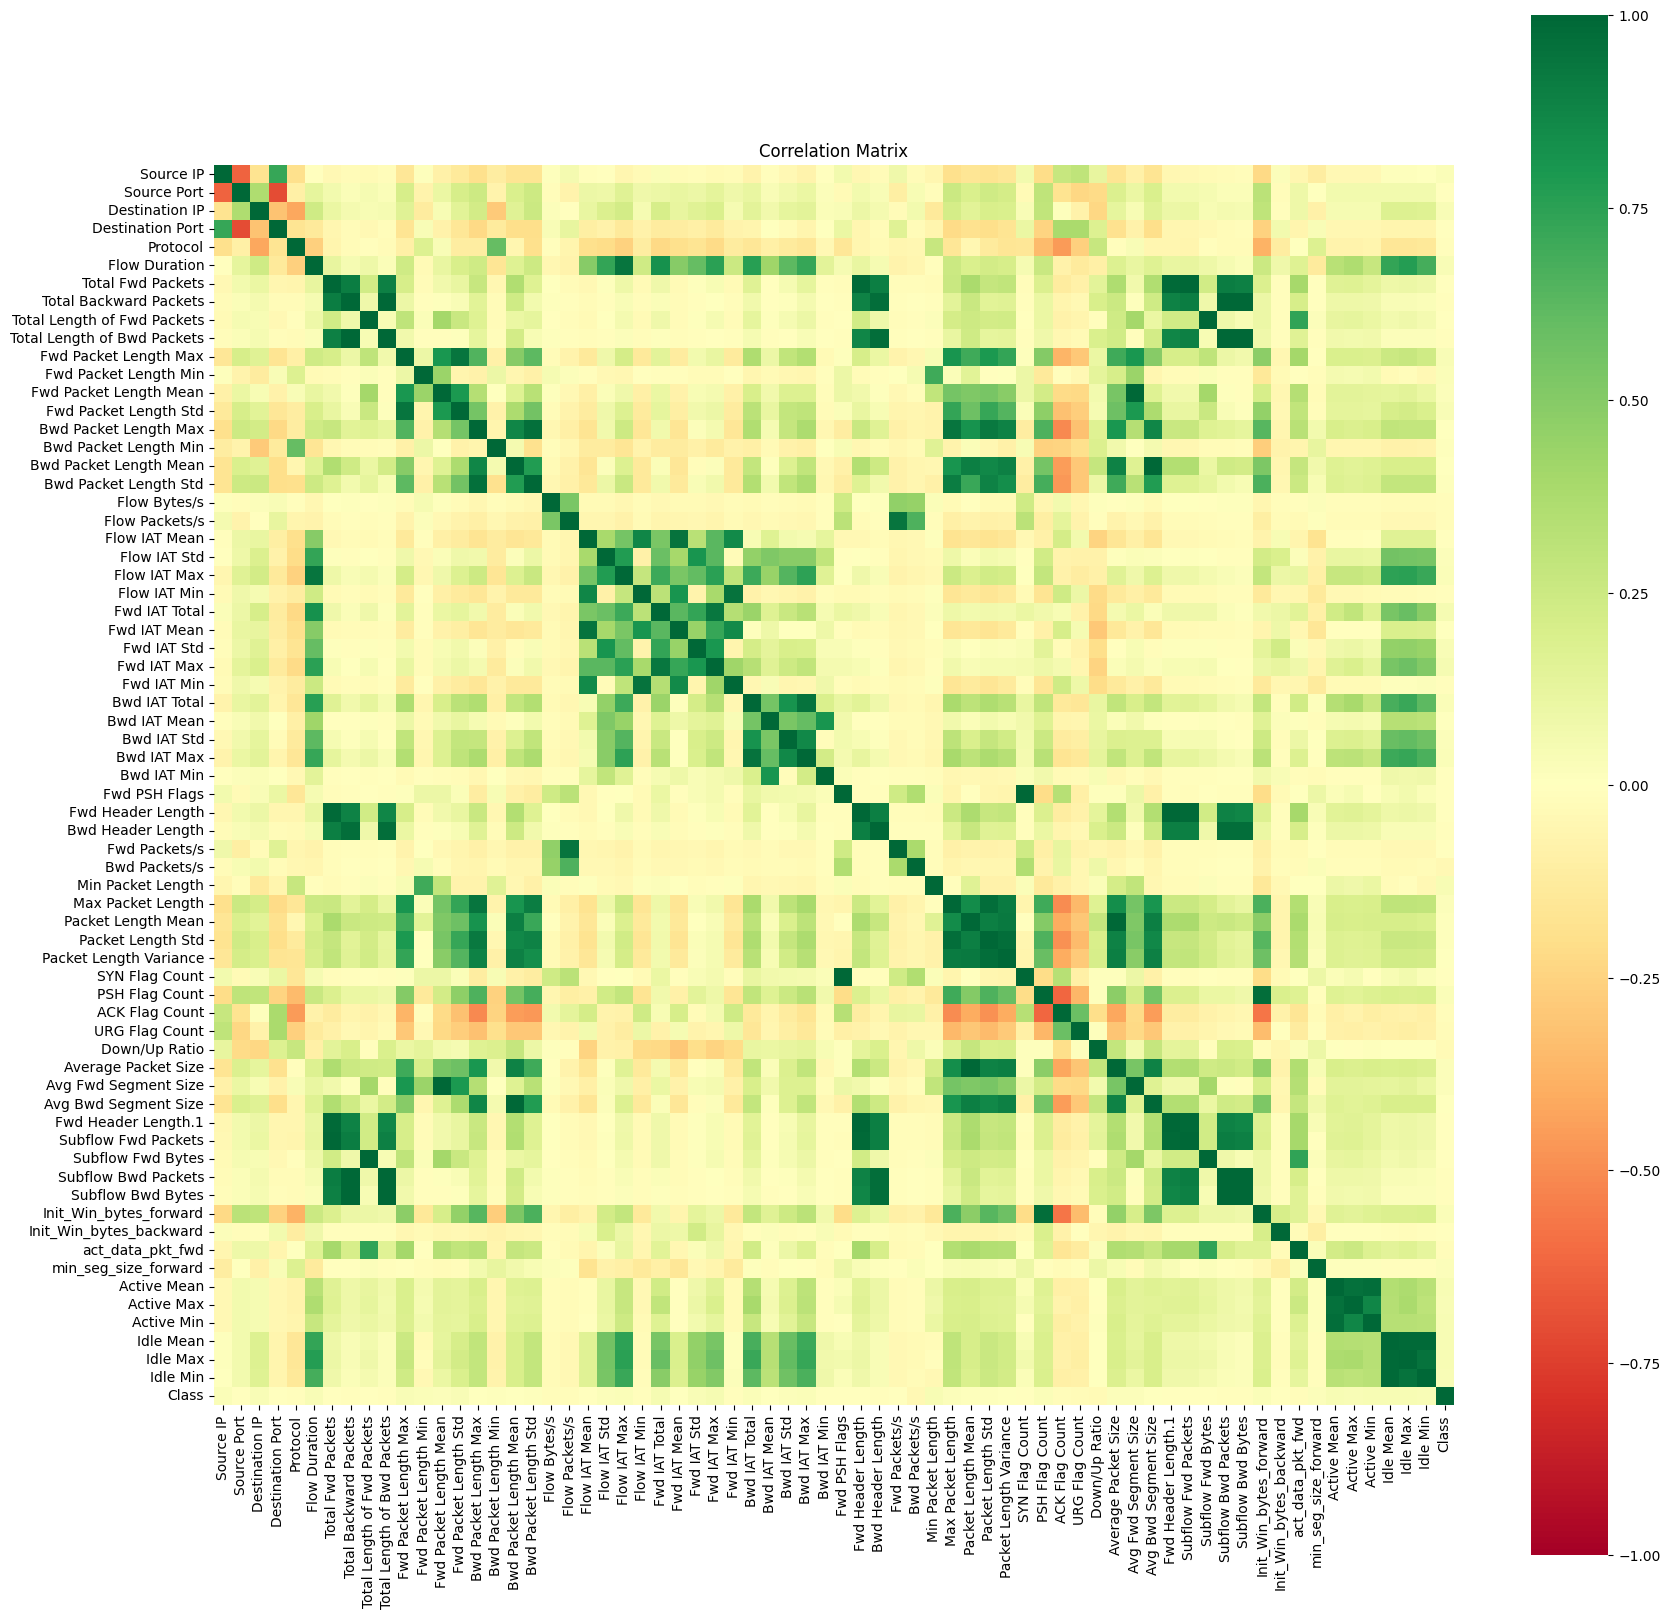

In [22]:
# apply standard-scalar on the training data to make all of the feature have equal weights
scaled_features_temp = X_train.apply(lambda x: (x- np.mean(x)) / np.std(x))  
scaled_features = pd.concat([scaled_features_temp, Y_train_binary_df], axis=1)

# print(tests)

# visualize correlation matrix of the training data after removing outliers and unneeded features
corr = scaled_features.corr()
_, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Correlation Matrix")
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="RdYlGn", square=True, ax=ax)
plt.show()

class_correlation = corr["Class"]


# # from the heatmap, we can notice that there is multiple feature having high positive correlation thus we can reduce dimensionality using PCA
# analyze_pca = PCA().fit(scaled_features)
# print(f"original variance ratio explained by each feature: {analyze_pca.explained_variance_ratio_} and total = {sum(analyze_pca.explained_variance_ratio_)}")

# # keep only 95% of the variance. so select the dimension reduction value
# cumulative_sum = np.cumsum(analyze_pca.explained_variance_ratio_)
# print(f"cumulative sum of variance ratio = {cumulative_sum}")
# new_dimension = np.argmin(np.abs(cumulative_sum - 0.95))
# print(f"new number of dimensions = {new_dimension}")

# # perform PCA reduction using new number of dimensions
# reduce_pca = PCA(n_components=new_dimension).fit(scaled_features)
# X_train = reduce_pca.transform(scaled_features)

<Figure size 640x480 with 0 Axes>

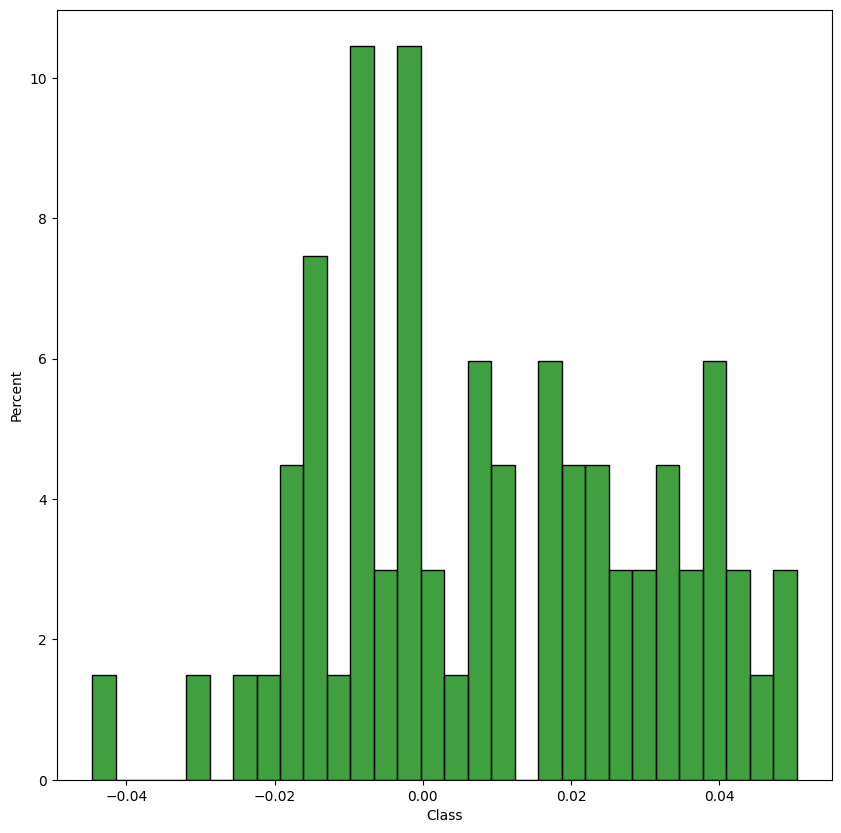

Number of features that are not zero correlated to the class are 27
Source IP                 0.03
Destination IP            0.04
Flow Duration             0.04
Fwd Packet Length Max     0.03
Fwd Packet Length Min     0.02
Fwd Packet Length Mean    0.02
Fwd Packet Length Std     0.03
Flow IAT Max              0.03
Fwd IAT Total             0.05
Fwd IAT Std               0.03
Fwd IAT Max               0.05
Bwd IAT Total             0.03
Bwd IAT Std               0.02
Bwd IAT Max               0.02
Bwd Packets/s            -0.04
Min Packet Length         0.04
PSH Flag Count            0.02
URG Flag Count           -0.02
Down/Up Ratio            -0.03
Avg Fwd Segment Size      0.02
Init_Win_bytes_forward    0.03
Active Mean               0.04
Active Max                0.04
Active Min                0.04
Idle Mean                 0.04
Idle Max                  0.04
Idle Min                  0.04
Name: Class, dtype: float64


In [23]:
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.histplot(class_correlation[:-1], stat="percent", kde=False, ax=ax, bins=30, color="green")
plt.show()

dummy = class_correlation[:-1]
print(f"Number of features that are not zero correlated to the class are {np.sum(np.abs(dummy)>0.02)}")
correlated_features = dummy[np.abs(dummy)>0.02]
print(correlated_features)

(129756, 27)


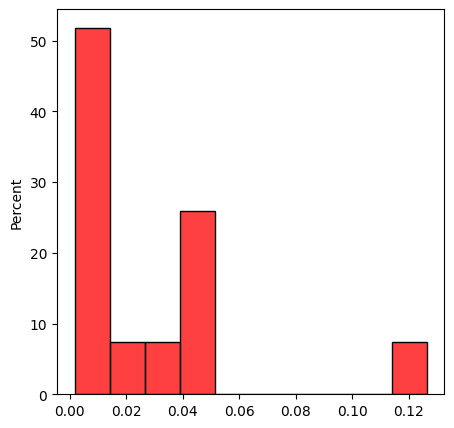

In [24]:
# apply information on the features to the get most important features

# Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
# the below function returns the information gain by each feature and its corresponding target in nat units.
# perform feature selection based on entropy as sklearn 

# print(correlated_features.index)
print(X_train[correlated_features.index].shape)

information_gain = mutual_info_classif(X_train[correlated_features.index].to_numpy(), Y_train.to_numpy())
_, ax = plt.subplots(figsize=(5, 5))
sns.histplot(information_gain, stat="percent", kde=False, ax=ax, bins=10, color="red")
plt.show()


In [25]:
# Take only the features with higher information gain
print(f"number of features that have information gain higher than 0.02 is {np.sum(information_gain>0.02)}")
highInformation_data = X_train[correlated_features.index[information_gain>0.02]]
print(highInformation_data.shape)

number of features that have information gain higher than 0.02 is 12
(129756, 12)


In [26]:
highInformation_data.columns

Index(['Source IP', 'Destination IP', 'Flow Duration', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow IAT Max',
       'Fwd IAT Total', 'Fwd IAT Max', 'Bwd Packets/s', 'Avg Fwd Segment Size',
       'Init_Win_bytes_forward'],
      dtype='object')

In [27]:
# norm = np.array([1, 2, 3])
# std = np.array([5, 4, 5])
# test = [[2, 3, 5],
#         [4, 7, 2],
#         [10, 12, 5]]

# print((test - std) / norm)

In [28]:
# calculate the mean and standard deviation of the training data
train_mean = np.mean(highInformation_data.to_numpy(), axis=0)
train_std = np.std(highInformation_data.to_numpy(), axis=0)

print(f"train mean = {train_mean}")
print(f"train standard deviation = {train_std}")

# standardize the training data
x_train_normalized = (highInformation_data.to_numpy() - train_mean) / train_std


train mean = [9.54762863e+01 8.11162282e+02 1.16387038e+07 2.31064691e+02
 6.93371574e+01 8.76827440e+01 1.01229504e+07 8.10354291e+06
 6.77492872e+06 1.35451510e+03 6.93371574e+01 2.27865029e+04]
train standard deviation = [2.93740174e+02 8.56636396e+02 2.30377958e+07 3.92416233e+02
 1.44475452e+02 1.65803986e+02 1.95824837e+07 1.98906217e+07
 1.60213677e+07 1.23318355e+04 1.44475452e+02 3.05613649e+04]


In [73]:
# calculate the mean and standard deviation of the unmodified training data
train_mean_unModified = np.mean(X_training_unModified.to_numpy(), axis=0)

# (we add a very small value to the standard deviation because in some columns the standard deviation was zero)
train_std_unModified = np.std(X_training_unModified.to_numpy(), axis=0) + 0.001

print(f"train mean = {train_mean_unModified}")
print(f"train standard deviation = {train_std_unModified}")

# standardize the training data 
x_train_unModified_normalized = (X_training_unModified.to_numpy() - train_mean_unModified) / train_std_unModified

train mean = [9.53437282e+01 3.86772473e+04 8.10895110e+02 5.72869840e+03
 8.29157620e+00 1.16271169e+07 6.75669930e+00 9.81543975e+00
 8.12059507e+02 1.00998162e+04 2.30863287e+02 1.34346823e+01
 6.93073688e+01 8.76200993e+01 3.51436237e+02 2.57528228e+01
 1.81801374e+02 1.34561840e+02 1.13390111e+05 5.35762953e+03
 3.11726227e+06 2.78092783e+06 1.01110552e+07 1.81560840e+06
 8.10207503e+06 3.14612535e+06 2.25311648e+06 6.77378985e+06
 1.84777093e+06 6.30801402e+06 1.08283967e+06 1.59837366e+06
 5.33657437e+06 3.98189432e+05 8.07972294e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.98482995e+02 2.75594406e+02
 4.00394892e+03 1.35368062e+03 9.65241039e+00 4.04934701e+02
 1.31073886e+02 1.58484118e+02 8.00027961e+04 1.14040162e-02
 8.07972294e-02 0.00000000e+00 3.24706448e-01 4.46394363e-01
 2.13768960e-01 0.00000000e+00 0.00000000e+00 6.07958771e-01
 1.44824863e+02 6.93073688e+01 1.81801374e+02 1.98482995e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000

In [66]:
print(x_train_unModified_normalized[0, 12])

-0.47940295199887256


In [71]:
# print(len(np.where(np.isnan(x_train_unModified_normalized))[0]))
# print(np.unique(np.where(np.isnan(x_train_unModified_normalized))[1]))

[]


In [74]:
# preprocess test data given the analysis we did on training data
def preprocess_test(X_test, X_testing_unModified):

    
    # drop the features we decided to drop in analysis phase
    X_test.drop(X_test.columns[indexes_of_columns_to_dropped], axis=1, inplace=True)

    # remove the feature the are not correlated to the output and have low information gain
    X_test = X_test[highInformation_data.columns]

    # apply IP format conversion 
    if USE_LABEL_ENCODER:
        X_test['Source IP'] = source_ip_encoder.transform(X_test['Source IP'].values.reshape(-1, 1)).flatten()
        X_test['Destination IP'] = destination_ip_encoder.transform(X_test['Destination IP'].values.reshape(-1, 1)).flatten()

        X_testing_unModified['Source IP'] = source_ip_encoder.transform(X_testing_unModified['Source IP'].values.reshape(-1, 1)).flatten()
        X_testing_unModified['Destination IP'] = destination_ip_encoder.transform(X_testing_unModified['Destination IP'].values.reshape(-1, 1)).flatten()

    else:
        X_test['Source IP'] = X_test['Source IP'].apply(convertIP)
        X_test['Destination IP'] = X_test['Destination IP'].apply(convertIP)

        X_testing_unModified['Source IP'] = X_testing_unModified['Source IP'].apply(convertIP)
        X_testing_unModified['Destination IP'] = X_testing_unModified['Destination IP'].apply(convertIP)

    # apply standard-scalar equation on test data using mean and standard deviation of training data
    X_test_unModified_normalized = (X_testing_unModified.to_numpy() - train_mean_unModified) / train_std_unModified
    X_test_normalized = (X_test.to_numpy() - train_mean) / train_std
    # i = 0
    # for series_name, series in X_test.items():
    #     X_test[series_name] = (X_test[series_name] - train_mean[i]) / train_std[i]
    #     i += 1

    # apply dimension reduction using PCA of the training data
    # reduced_test_data = reduce_pca.transform(X_test)
    # return reduced_test_data

    return X_test_normalized, X_test_unModified_normalized

dummy2 = copy.deepcopy(X_test)
dummy3 = copy.deepcopy(X_testing_unModified)
X_test_normalized, X_test_unModified_normalized = preprocess_test(dummy2, dummy3)
# X_test

In [32]:
X_test_normalized.shape

(44371, 12)

In [33]:
X_test_unModified_normalized.shape

(44371, 82)

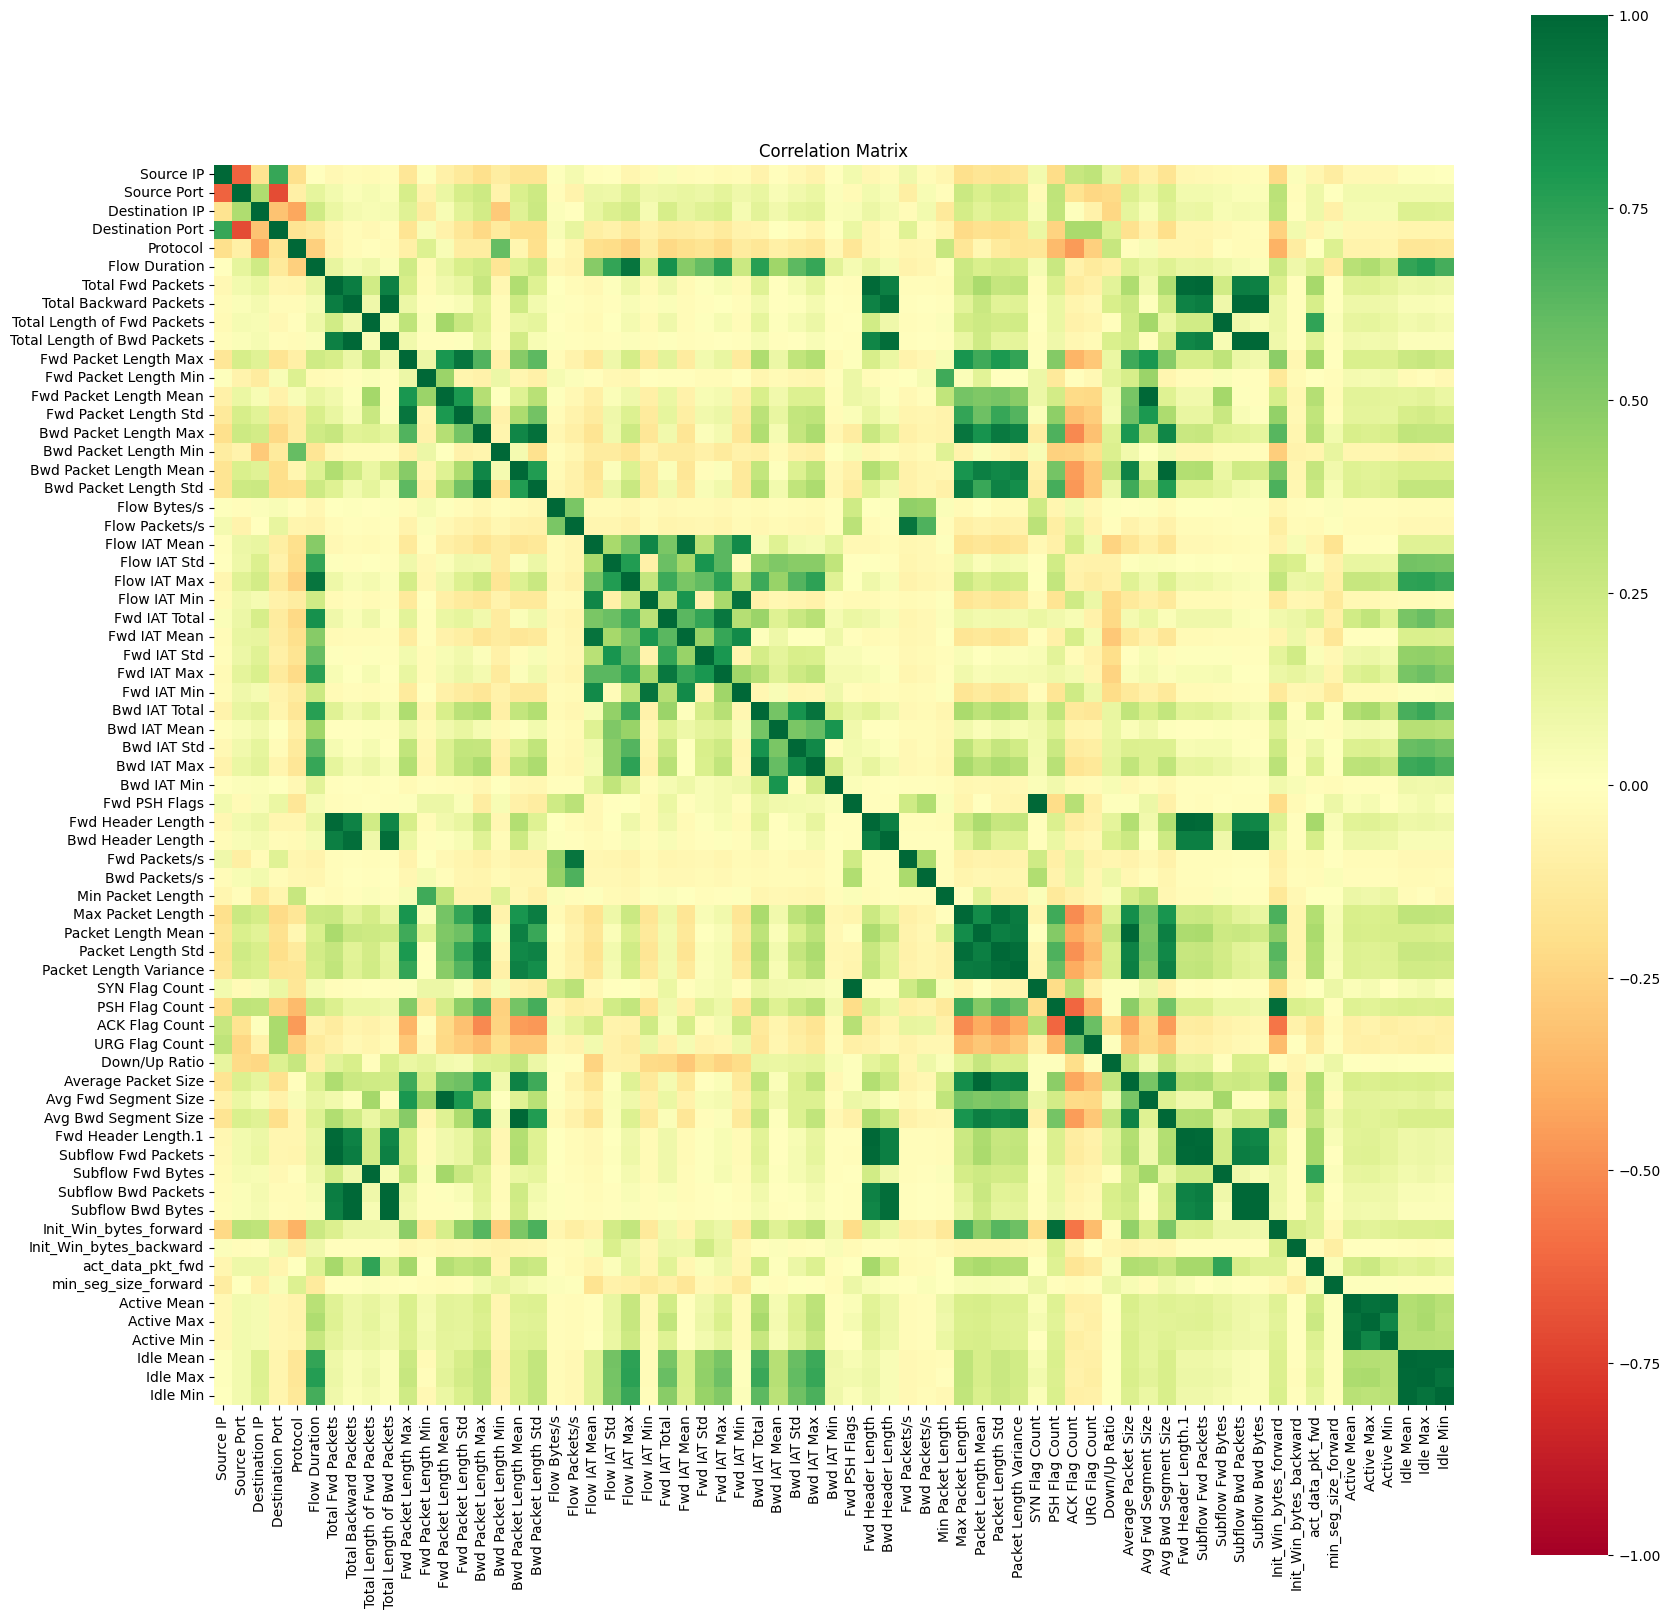

original variance ratio explained by each feature: [2.16688502e-01 1.28211880e-01 1.08513482e-01 5.99161864e-02
 5.37825377e-02 4.71213394e-02 3.95796086e-02 3.77148799e-02
 3.63208666e-02 2.92822137e-02 2.81302683e-02 2.60239325e-02
 2.19051260e-02 1.90227092e-02 1.55935030e-02 1.39957024e-02
 1.30833064e-02 1.13923595e-02 1.07736854e-02 9.06517270e-03
 8.69111537e-03 7.57683344e-03 7.26260244e-03 6.36498405e-03
 5.55816062e-03 5.13255068e-03 4.83470158e-03 4.63552049e-03
 3.68212360e-03 3.43941676e-03 2.94003852e-03 2.70207849e-03
 1.80615628e-03 1.44098455e-03 1.21425228e-03 1.06168390e-03
 8.86454569e-04 7.86933023e-04 6.66956843e-04 6.12755235e-04
 4.70221268e-04 4.33253652e-04 3.01627010e-04 2.87749296e-04
 2.50426545e-04 2.27189759e-04 1.79441680e-04 1.47363131e-04
 1.05865205e-04 5.61777252e-05 3.18342008e-05 3.13009751e-05
 1.70794988e-05 1.45440365e-05 1.29132166e-05 8.48677714e-06
 5.98349307e-06 4.97764905e-06 6.66574708e-23 1.11934320e-24
 4.27342720e-32 8.08127897e-33 5.5

In [34]:
# apply PCA to reduce dimensionality for the data to be easily visualized

# apply standard-scalar on the training data to make all of the feature have equal weights
X_train_visual = copy.deepcopy(X_train)
scaled_features = X_train_visual.apply(lambda x: (x- np.mean(x)) / np.std(x))  
# scaled_features = pd.concat([scaled_features_temp, Y_train_binary], axis=1)

# visualize correlation matrix of the training data after removing outliers and unneeded features
corr = scaled_features.corr()
_, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Correlation Matrix")
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="RdYlGn", square=True, ax=ax)
plt.show()


# # from the heatmap, we can notice that there is multiple feature having high positive correlation thus we can reduce dimensionality using PCA
analyze_pca = PCA().fit(scaled_features)
print(f"original variance ratio explained by each feature: {analyze_pca.explained_variance_ratio_} and total = {sum(analyze_pca.explained_variance_ratio_)}")

# keep only 51% of the variance. so select the dimension reduction value
cumulative_sum = np.cumsum(analyze_pca.explained_variance_ratio_)
print(f"cumulative sum of variance ratio = {cumulative_sum}")
new_dimension = np.argmin(np.abs(cumulative_sum - 0.51))
print(f"new number of dimensions = {new_dimension}")

# perform PCA reduction using new number of dimensions
reduce_pca = PCA(n_components=new_dimension).fit(scaled_features)
X_train_transformed = reduce_pca.transform(scaled_features)


<Axes: xlabel='f1', ylabel='f2'>

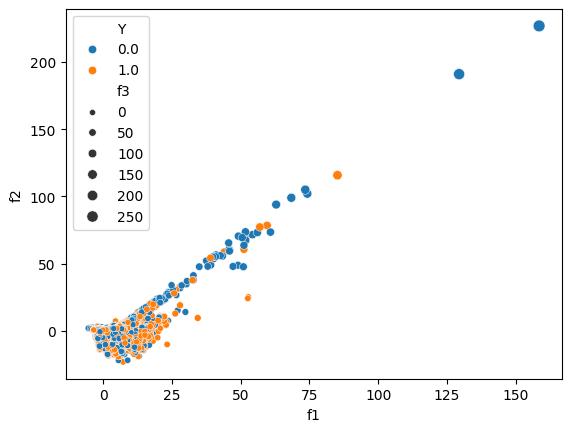

In [35]:
# visualization of feature in high dimensions
features_to_be_plotted_numpy = np.concatenate((X_train_transformed, Y_train_binary.reshape(-1, 1)), axis=1)
features_to_be_plotted_df = pd.DataFrame(data=features_to_be_plotted_numpy, columns=['f1', 'f2', 'f3', 'Y'], index=np.arange(len(Y_train_binary)))
sns.scatterplot(features_to_be_plotted_df, x='f1', y='f2', size='f3', hue='Y')
# sn.scatterplot(y_val.head(100))
# features_to_be_plotted_df
# scaled_features = pd.concat([scaled_features_temp, Y_train_binary], axis=1)


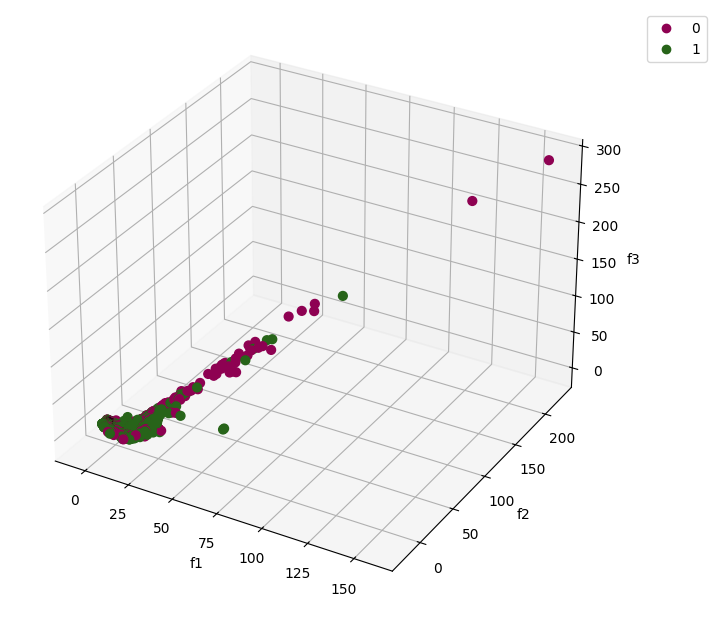

In [36]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


# plot
sc = ax.scatter(features_to_be_plotted_df['f1'].to_numpy(), features_to_be_plotted_df['f2'].to_numpy(), features_to_be_plotted_df['f3'].to_numpy(), 
               c=features_to_be_plotted_df['Y'].to_numpy(), s=40, marker='o', cmap=colormaps['PiYG'], alpha=1)
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('f3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()


In [37]:
def print_statistics(model, X_test, Y_test, X_train, Y_train):

    # train the model and calculate the time it takes to train
    start_time = time.time()
    model.fit(X_train, Y_train)
    train_time = time.time() - start_time

    # compute the time taken for the prediction 
    start_time = time.time()
    Y_pred = model.predict(X_test)
    predict_time = time.time() - start_time   

    # compute confusion matrix (ravel is numpy function to flatten the matrix)
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred, labels=[0, 1]).ravel() 
    
    # compute accuracy, recall, precision and F1-score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = (2 * recall * precision) / (precision + recall) 

    # compute model size
    file = pickle.dumps(model)
    model_size = sys.getsizeof(file)


    # store confusion matrix in a string using pretty table
    table = PrettyTable()
    table.field_names = ["", "Trojan(Gold)", "Not Trojan(Gold)"]
    table.add_row(["Trojan(Pred)", tp, fp])
    table.add_row(["Not Trojan(Pred)", fn, tn])

    # print the results and statistics
    print( "==============================\n"
            f"model Name: {model.getName()}\n"
            "==============================\n"
            f"best hyper parameters are:\n{model.getParameters()}\n"
            "------------------------------\n"
            "confusion matrix:\n"
            f"{table.get_string()}\n"
            "------------------------------\n"
            f"Accuracy = {round(accuracy, 2)}\n"
            f"Recall = {round(recall, 2)}\n"
            f"Precision = {round(precision, 2)}\n"
            f"F1-Score = {round(f1_score, 2)}\n"
            f"Model Size = {round(model_size, 2)} bytes\n"
            f"Training Time = {round(train_time, 2)} sec\n"
            f"Prediction Time = {round(predict_time, 2)} sec\n"
            "------------------------------\n\n"
            )

    # Y_true  must me either 0 or 1, so create a copy and make Trojan = 1 and Benign = 0
    Y_true = copy.deepcopy(Y_test)
    # Y_true[Y_true == 'Trojan'] = 1
    # Y_true[Y_true == 'Benign'] = 0
    # Y_true = Y_true.astype(np.int8)
        
    # plot the AUC-ROC graph
    Y_pred_probability = model.predict_probability(X_test)
    fpr_arr, tpr_arr, _ = roc_curve(Y_true, Y_pred_probability, pos_label=1)
    auc = roc_auc_score(Y_true, Y_pred_probability)
    plt.plot(fpr_arr, tpr_arr, label=f"AUC = {round(auc, 2)}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    

In [306]:
X_test_normalized.shape, Y_test_binary.shape, x_train_normalized.shape, Y_train_binary.shape

((44371, 12), (44371,), (129756, 12), (129756,))

In [38]:
# ZeroR classifier

# ZeroR uses Zero Features to predict, what is does is just get the most frequent class in the dataset and then predict any
# test point to be that most frequent class
class ZeroR():

    def __init__(self):
        pass

    # compute, Plot and Save AUC-ROC graph
    def predict_probability(self, X_test):
        return np.full(len(X_test), self.probability)

    # return the name of the model
    def getName(self):
        return "ZeroR"

    # returns the hyperparameters of the model:
    def getParameters(self):
        return "-"

    # get the most frequent class
    # class list is a dictionary where they key is the class and value is the frequency of the class in the dataset
    def fit(self, X_train, Y_train):
        most_common = Counter(Y_train).most_common(1)
        self.model_Predicted = most_common[0][0]
        self.probability = most_common[0][1] / len(Y_train)

    # just return the most frequent class
    def predict(self, X_test):
        return np.full(len(X_test), self.model_Predicted)

    # get the score of correctly predicting the classes
    def score(self, X_test, Y_test):
        return len(Y_test[Y_test == self.model_Predicted]) / len(Y_test)

zeroR = ZeroR()


model Name: ZeroR
best hyper parameters are:
-
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    22671     |      21700       |
| Not Trojan(Pred) |      0       |        0         |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.51
Recall = 1.0
Precision = 0.51
F1-Score = 0.68
Model Size = 215 bytes
Training Time = 0.02 sec
Prediction Time = 0.0 sec
------------------------------




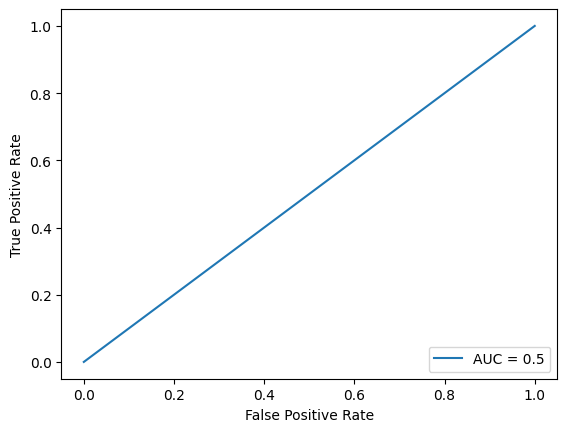

In [39]:
# For Data before all processing 
print_statistics(zeroR, X_test_unModified_normalized, Y_test_unModified_binary, x_train_unModified_normalized, Y_train_unModified_binary)

model Name: ZeroR
best hyper parameters are:
-
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    22671     |      21700       |
| Not Trojan(Pred) |      0       |        0         |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.51
Recall = 1.0
Precision = 0.51
F1-Score = 0.68
Model Size = 215 bytes
Training Time = 0.02 sec
Prediction Time = 0.0 sec
------------------------------




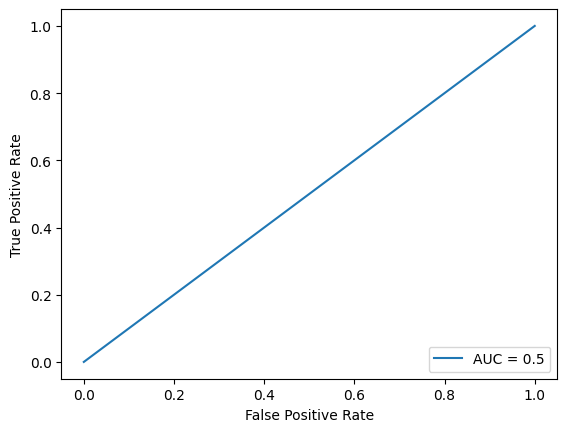

In [40]:
# For Data after all processing 
print_statistics(zeroR, X_test_normalized, Y_test_binary, x_train_normalized, Y_train_binary)

In [41]:
# logistic regression classifier

#
class Logistic_Regression():
    
    # compute, Plot and Save AUC-ROC graph
    def predict_probability(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    # return the name of the model
    def getName(self):
        return "Logistic Regression"

    # returns the hyperparameters of the model:
    def getParameters(self):
        return self.model.get_params()
    

    # assign the best fitted model
    def setModel(self, model):
        self.model = model
    
    
    def __init__(self):
        # penalty:            Specify the norm of the penalty (regularization is applied by default)
        # dual:               Prefer dual=False when n_samples > n_features.
        # tol:                Tolerance for stopping criteria.
        # C:                  Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
        # fit_intercept:      Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
        # intercept_scaling:  Useful only when the solver ‘liblinear’ is used and self.fit_intercept is set to True.The intercept becomes intercept_scaling * synthetic_feature_weight.
        # class_weight:       Weights associated with classes in the form {class_label: weight}
        # random_state:       Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
        # solver:             Algorithm to use in the optimization problem.
        # max_iter:           Maximum number of iterations taken for the solvers to converge.
        # multi_class:        If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary.
        # verbose:            For the liblinear and lbfgs solvers set verbose to any positive number for verbosity.
        # warm_start:         When set to True, reuse the solution of the previous call to fit as initialization.
        # n_jobs:             Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”.
        # l1_ratio:           The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. the penalty is a combination of L1 and L2.
        self.model = LogisticRegression(penalty='l2', dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling= 1.0,
                                        class_weight=None, random_state=None, solver='newton-cg', max_iter=100,
                                        multi_class='ovr', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=0.5)

    # train the model
    def fit(self, X_features, Y_labels):
        self.model.fit(X_features, Y_labels)

    # predict output
    def predict(self, X_test):
        return self.model.predict(X_test)

    # compute score
    def score(self, X_test, Y_test):
        return self.model.score(X_test, Y_test)


# create the object
logisticReg = Logistic_Regression()

# logisticReg.fit(x_train_normalized, Y_train_binary)
# print(logisticReg.predict_probability(X_test))
# print(logisticReg.score(X_test, Y_test))
# print_statistics(logisticReg, X_test_normalized, Y_test_binary, x_train_normalized, Y_train_binary)

In [42]:
# applied gridsearchCV on unMadified X_train and it ran for 6 hours until interrupted by me as it was taking too much time compared to 7 minutes only for modified X_train.
# we should have decreased the window of the search to be around the optimal value we found so that we may found another optimal values but this process would take a long time for a useless data

# apply grid search CV on logistic regression to get the best hyper-parameters
parameters = {'penalty':('l2', 'l1', 'elasticnet'), 'C':(0.01, 1, 100), 
              'solver': ('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'), 
              'max_iter': (100, 1000, 10000), 'multi_class': ('auto', 'ovr', 'multinomial'), 
              }

# grid search cv uses KFold cross-validation to find the best match
search_result = GridSearchCV(estimator=logisticReg.model, param_grid=parameters, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=4, pre_dispatch='2*n_jobs', error_score=0.0, return_train_score=True)
search_result.fit(x_train_normalized, Y_train_binary)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=5, error_score=0.0,
             estimator=LogisticRegression(intercept_scaling=1.0, l1_ratio=0.5,
                                          multi_class='ovr', n_jobs=-1,
                                          solver='newton-cg'),
             n_jobs=-1,
             param_grid={'C': (0.01, 1, 100), 'max_iter': (100, 1000, 10000),
                         'multi_class': ('auto', 'ovr', 'multinomial'),
                         'penalty': ('l2', 'l1', 'elasticnet'),
                         'solver': ('lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga')},
             return_train_score=True, scoring='accuracy', verbose=4)

In [77]:
print(search_result.best_score_)
print(search_result.best_params_)
# print(search_result.best_estimator_.score(X_test, Y_test))
# print(search_result.best_estimator_.score(X_train, Y_train))

# search_result.best_estimator_.fit(X_training_unModified, Y_training_unModified)
# print(search_result.best_estimator_.score(X_testing_unModified, Y_testing_unModified))


0.5322605138152567
{'C': 0.01, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}


In [44]:
best_logistic_model = LogisticRegression(penalty='l1', dual=False, tol=1e-4, C=0.01, fit_intercept=True, intercept_scaling= 1.0,
                                        class_weight=None, random_state=None, solver='liblinear', max_iter=100,
                                        multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=0.5)
logisticReg.setModel(best_logistic_model)

In [48]:
print(np.argwhere(np.isnan(x_train_unModified_normalized)).shape)

(1597332, 2)


model Name: Logistic Regression
best hyper parameters are:
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    12898     |      10070       |
| Not Trojan(Pred) |     9773     |      11630       |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.55
Recall = 0.57
Precision = 0.56
F1-Score = 0.57
Model Size = 1465 bytes
Training Time = 16.19 sec
Prediction Time = 0.01 sec
------------------------------




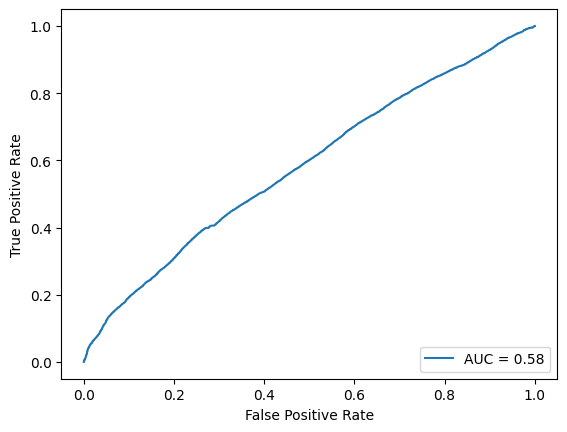

In [75]:
print_statistics(logisticReg, X_test_unModified_normalized, Y_test_unModified_binary,  x_train_unModified_normalized, Y_train_unModified_binary)

model Name: Logistic Regression
best hyper parameters are:
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratio': 0.5, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    13285     |      11137       |
| Not Trojan(Pred) |     9386     |      10563       |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.54
Recall = 0.59
Precision = 0.54
F1-Score = 0.56
Model Size = 902 bytes
Training Time = 0.8 sec
Prediction Time = 0.0 sec
------------------------------




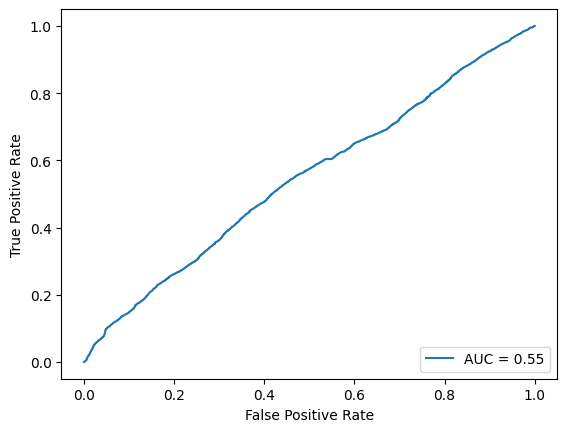

In [45]:
print_statistics(logisticReg, X_test_normalized, Y_test_binary, x_train_normalized, Y_train_binary)

In [86]:
# Support Vector Machine classifier

# The implementation is based on libsvm.
class Support_Vector_Machine():

    # compute, Plot and Save AUC-ROC graph
    def predict_probability(self, X_test):
        return self.model.predict_proba(X_test)[:, 0]

    # return the name of the model
    def getName(self):
        return "Support Vector Machine"

    # returns the hyperparameters of the model:
    def getParameters(self):
        return self.model.get_params()

    # assign the best fitted model
    def setModel(self, model):
        self.model = model

    def __init__(self):
        # C:                          Regularization parameter. The strength of the regularization is inversely proportional to C. The penalty is a squared l2 penalty.
        # kernel:                     Specifies the kernel type to be used in the algorithm.
        # degree:                     Degree of the polynomial kernel function (‘poly’).
        # gamma:                      Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
        # coef0:                      Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
        # shrinking:                  Whether to use the shrinking heuristic.
        # probability:                Whether to enable probability estimates.
        # tol:                        Tolerance for stopping criterion.
        # cache_size:                 Specify the size of the kernel cache (in MB).
        # class_weight:               Set the parameter C of class i to class_weight[i]*C for SVC.
        # verbose:                    Enable verbose output.
        # max_iter:                   Hard limit on iterations within solver, or -1 for no limit.
        # decision_function_shape:    Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2).
        # break_ties:                 If true, decision_function_shape='ovr', and number of classes > 2, predict will break ties according to the confidence values of decision_function; otherwise the first class among the tied classes is returned. Please note that breaking ties comes at a relatively high computational cost compared to a simple predict.
        # random_state:               Controls the pseudo random number generation for shuffling the data for probability estimates. Ignored when probability is False. Pass an int for reproducible output across multiple function calls.
        self.model = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True,
                         tol=1e-3, cache_size=200, class_weight=None, verbose=False, max_iter=300,
                         decision_function_shape='ovr', break_ties=False, random_state=None)
        
    # train the model
    def fit(self, X_features, Y_labels):
        self.model.fit(X_features, Y_labels)

    # predict output
    def predict(self, X_test):
        return self.model.predict(X_test)

    # compute score
    def score(self, X_test, Y_test):
        return self.model.score(X_test, Y_test)

svm = Support_Vector_Machine()
# svm.fit(X_train, Y_train)
# print(svm.score(X_train, Y_train))
# print(svm.score(X_test, Y_test))

# print_statistics(svm, X_test_normalized, Y_test_binary, x_train_normalized, Y_train_binary)

In [81]:
# apply grid search CV on SVM to get the best hyper-parameters
# we should have decreased the window of the search to be around the optimal value we found so that we may found another optimal values
parameters = {'degree':(3, 7, 11), 'C':(0.01, 1, 100), 
              'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('scale', 'auto'), 
              'max_iter': (100, 500, 1000), 'decision_function_shape': ('ovo', 'ovr'), 
              }

# grid search cv uses KFold cross-validation to find the best match
search_result = GridSearchCV(estimator=svm.model, param_grid=parameters, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=4, pre_dispatch='2*n_jobs', error_score=0.0, return_train_score=True)
search_result.fit(x_train_normalized, Y_train_binary)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, error_score=0.0,
             estimator=SVC(kernel='linear', max_iter=300, probability=True),
             n_jobs=-1,
             param_grid={'C': (0.01, 1, 100),
                         'decision_function_shape': ('ovo', 'ovr'),
                         'degree': (3, 7, 11), 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                         'max_iter': (100, 500, 1000)},
             return_train_score=True, scoring='accuracy', verbose=4)

In [82]:
print(search_result.best_score_)
print(search_result.best_params_)

0.5113212490570178
{'C': 1, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 100}


In [87]:
best_svc = SVC(C=1.0, kernel='poly', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True,
                         tol=1e-3, cache_size=200, class_weight=None, verbose=False, max_iter=100,
                         decision_function_shape='ovo', break_ties=False, random_state=None)
svm.setModel(search_result.best_estimator_)

model Name: Support Vector Machine
best hyper parameters are:
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 100, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    22669     |      21692       |
| Not Trojan(Pred) |      2       |        8         |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.51
Recall = 1.0
Precision = 0.51
F1-Score = 0.68
Model Size = 97294 bytes
Training Time = 21.37 sec
Prediction Time = 0.31 sec
------------------------------




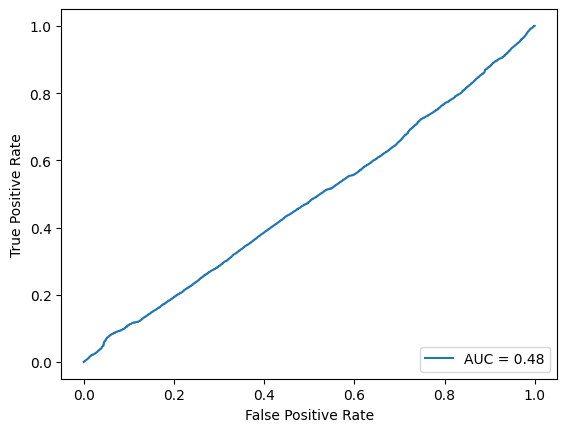

In [88]:
print_statistics(svm, X_test_unModified_normalized, Y_test_unModified_binary, x_train_unModified_normalized, Y_train_unModified_binary)

model Name: Support Vector Machine
best hyper parameters are:
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 100, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    22654     |      21696       |
| Not Trojan(Pred) |      17      |        4         |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.51
Recall = 1.0
Precision = 0.51
F1-Score = 0.68
Model Size = 24377 bytes
Training Time = 12.98 sec
Prediction Time = 0.27 sec
------------------------------




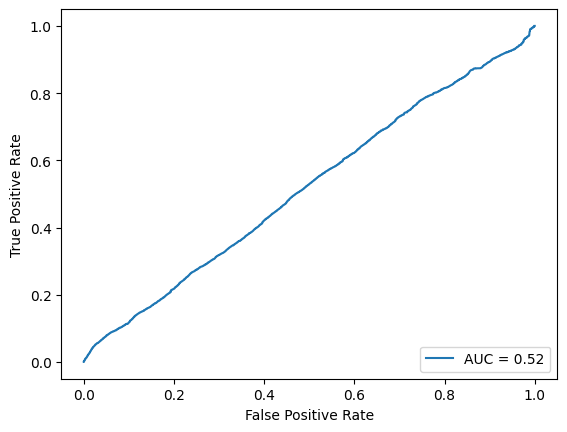

In [89]:
print_statistics(svm, X_test_normalized, Y_test_binary, x_train_normalized, Y_train_binary)

In [90]:
# Adaboost (Adaptive Boosting Classifier)


class Adaptive_Boosting_Classifier():


    # compute, Plot and Save AUC-ROC graph
    def predict_probability(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    # return the name of the model
    def getName(self):
        return "Adaptive Boosting Classifier"

    # returns the hyperparameters of the model:
    def getParameters(self):
        return self.model.get_params()

    # assign the best fitted model
    def setModel(self, model):
        self.model = model


    def __init__(self):
        # estimator:       The base estimator from which the boosted ensemble is built. (in case estimator = None then the estimator is DecisionTreeClassifier initialized with max_depth=1.)
        # n_estimators:    The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
        # learning_rate:   Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier
        # algorithm:       If ‘SAMME.R’ then use the SAMME.R real boosting algorithm. estimator must support calculation of class probabilities. If ‘SAMME’ then use the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.
        # random_state:    Controls the random seed given at each estimator at each boosting iteration.
        self.model = AdaBoostClassifier(estimator=None, n_estimators=50, learning_rate=0.5, algorithm="SAMME.R", random_state=0)
        
    # train the model
    def fit(self, X_features, Y_labels):
        self.model.fit(X_features, Y_labels)

    # predict output
    def predict(self, X_test):
        return self.model.predict(X_test)

    # compute score
    def score(self, X_test, Y_test):
        return self.model.score(X_test, Y_test)
    
adaboost = Adaptive_Boosting_Classifier()

In [ ]:
# TODO: plot learning curve for each model

67114


In [92]:
# apply grid search CV on SVM to get the best hyper-parameters
# we should have decreased the window of the search to be around the optimal value we found so that we may found another optimal values
parameters = {'n_estimators':(10, 100, 1000), 'learning_rate':(0.01, 1, 100), 
              'algorithm': ('SAMME', 'SAMME.R')
              }

# grid search cv uses KFold cross-validation to find the best match
search_result = GridSearchCV(estimator=adaboost.model, param_grid=parameters, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=4, pre_dispatch='2*n_jobs', error_score=0.0, return_train_score=True)
search_result.fit(x_train_normalized, Y_train_binary)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, error_score=0.0,
             estimator=AdaBoostClassifier(learning_rate=0.5, random_state=0),
             n_jobs=-1,
             param_grid={'algorithm': ('SAMME', 'SAMME.R'),
                         'learning_rate': (0.01, 1, 100),
                         'n_estimators': (10, 100, 1000)},
             return_train_score=True, scoring='accuracy', verbose=4)

In [93]:
print(search_result.best_score_)
print(search_result.best_params_)

0.7374379809672607
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 1000}


In [140]:
best_adaboost = AdaBoostClassifier(estimator=None, n_estimators=5000, learning_rate=1, algorithm="SAMME.R", random_state=0)
adaboost.setModel(best_adaboost)

model Name: Adaptive Boosting Classifier
best hyper parameters are:
{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 1, 'n_estimators': 5000, 'random_state': 0}
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    15207     |       3081       |
| Not Trojan(Pred) |     7464     |      18619       |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.76
Recall = 0.67
Precision = 0.83
F1-Score = 0.74
Model Size = 2731712 bytes
Training Time = 3433.29 sec
Prediction Time = 72.56 sec
------------------------------




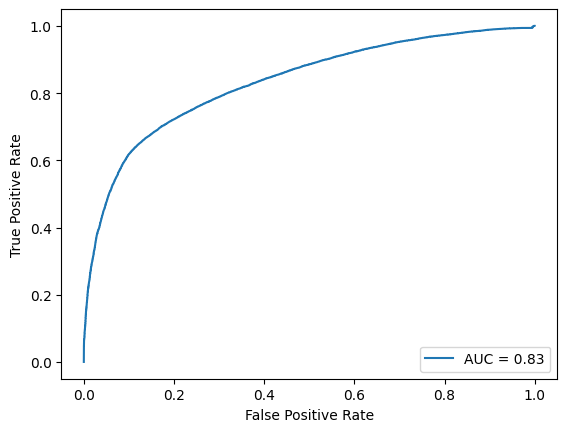

In [142]:
print_statistics(adaboost, X_test_unModified_normalized, Y_test_unModified_binary, x_train_unModified_normalized, Y_train_unModified_binary)

model Name: Adaptive Boosting Classifier
best hyper parameters are:
{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 1, 'n_estimators': 5000, 'random_state': 0}
------------------------------
confusion matrix:
+------------------+--------------+------------------+
|                  | Trojan(Gold) | Not Trojan(Gold) |
+------------------+--------------+------------------+
|   Trojan(Pred)   |    14440     |       2918       |
| Not Trojan(Pred) |     8231     |      18782       |
+------------------+--------------+------------------+
------------------------------
Accuracy = 0.75
Recall = 0.64
Precision = 0.83
F1-Score = 0.72
Model Size = 2731712 bytes
Training Time = 969.3 sec
Prediction Time = 23.45 sec
------------------------------




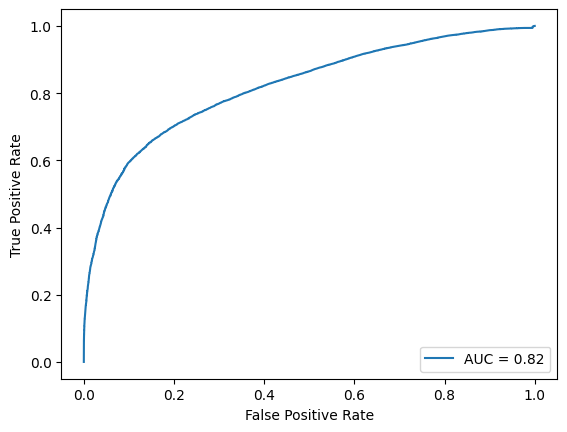

In [141]:
print_statistics(adaboost, X_test_normalized, Y_test_binary, x_train_normalized, Y_train_binary)

In [26]:
models,predictions = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None).fit(x_train_normalized, X_test_normalized, Y_train_binary, Y_test_binary)
models

 97%|█████████▋| 28/29 [8:51:00<10:18, 618.56s/it]    

[LightGBM] [Info] Number of positive: 67174, number of negative: 64274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 131448, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511031 -> initscore=0.044131
[LightGBM] [Info] Start training from score 0.044131


100%|██████████| 29/29 [8:51:02<00:00, 1098.71s/it]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.72               0.72    None      0.72   
ExtraTreesClassifier               0.71               0.71    None      0.71   
BaggingClassifier                  0.71               0.71    None      0.71   
KNeighborsClassifier               0.69               0.69    None      0.69   
DecisionTreeClassifier             0.68               0.68    None      0.68   
ExtraTreeClassifier                0.67               0.67    None      0.67   
LGBMClassifier                     0.65               0.65    None      0.65   
NuSVC                              0.62               0.63    None      0.61   
SVC                                0.61               0.61    None      0.61   
AdaBoostClassifier                 0.59               0.59    None      0.59   
LogisticRegression                 0.54               0.54    None      0.53   
LinearSVC                          0.54               0.53    None      0.53   
CalibratedClassifierCV             0.54               0.53    None      0.53   
NearestCentroid                    0.53               0.53    None      0.53   
RidgeClassifierCV                  0.54               0.53    None      0.53   
LinearDiscriminantAnalysis         0.53               0.53    None      0.53   
RidgeClassifier                    0.53               0.53    None      0.53   
BernoulliNB                        0.53               0.53    None      0.53   
QuadraticDiscriminantAnalysis      0.52               0.53    None      0.44   
SGDClassifier                      0.52               0.52    None      0.52   
PassiveAggressiveClassifier        0.52               0.52    None      0.52   
GaussianNB                         0.50               0.51    None      0.44   
DummyClassifier                    0.51               0.50    None      0.35   
Perceptron                         0.49               0.49    None      0.49   

                               Time Taken  
Model                                      
RandomForestClassifier             145.78  
ExtraTreesClassifier                35.30  
BaggingClassifier                   80.34  
KNeighborsClassifier                 6.89  
DecisionTreeClassifier              15.22  
ExtraTreeClassifier                  1.42  
LGBMClassifier                       1.74  
NuSVC                            29369.69  
SVC                               2095.41  
AdaBoostClassifier                  46.81  
LogisticRegression                   1.28  
LinearSVC                           43.33  
CalibratedClassifierCV               3.42  
NearestCentroid                      1.02  
RidgeClassifierCV                    1.55  
LinearDiscriminantAnalysis           1.52  
RidgeClassifier                      1.35  
BernoulliNB                          1.43  
QuadraticDiscriminantAnalysis        1.20  
SGDClassifier                        1.71  
PassiveAggressiveClassifier          1.20  
GaussianNB                           1.11  
DummyClassifier                      0.94  
Perceptron                           1.25

In [27]:
predictions

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.72               0.72    None      0.72   
ExtraTreesClassifier               0.71               0.71    None      0.71   
BaggingClassifier                  0.71               0.71    None      0.71   
KNeighborsClassifier               0.69               0.69    None      0.69   
DecisionTreeClassifier             0.68               0.68    None      0.68   
ExtraTreeClassifier                0.67               0.67    None      0.67   
LGBMClassifier                     0.65               0.65    None      0.65   
NuSVC                              0.62               0.63    None      0.61   
SVC                                0.61               0.61    None      0.61   
AdaBoostClassifier                 0.59               0.59    None      0.59   
LogisticRegression                 0.54               0.54    None      0.53   
LinearSVC                          0.54               0.53    None      0.53   
CalibratedClassifierCV             0.54               0.53    None      0.53   
NearestCentroid                    0.53               0.53    None      0.53   
RidgeClassifierCV                  0.54               0.53    None      0.53   
LinearDiscriminantAnalysis         0.53               0.53    None      0.53   
RidgeClassifier                    0.53               0.53    None      0.53   
BernoulliNB                        0.53               0.53    None      0.53   
QuadraticDiscriminantAnalysis      0.52               0.53    None      0.44   
SGDClassifier                      0.52               0.52    None      0.52   
PassiveAggressiveClassifier        0.52               0.52    None      0.52   
GaussianNB                         0.50               0.51    None      0.44   
DummyClassifier                    0.51               0.50    None      0.35   
Perceptron                         0.49               0.49    None      0.49   

                               Time Taken  
Model                                      
RandomForestClassifier             145.78  
ExtraTreesClassifier                35.30  
BaggingClassifier                   80.34  
KNeighborsClassifier                 6.89  
DecisionTreeClassifier              15.22  
ExtraTreeClassifier                  1.42  
LGBMClassifier                       1.74  
NuSVC                            29369.69  
SVC                               2095.41  
AdaBoostClassifier                  46.81  
LogisticRegression                   1.28  
LinearSVC                           43.33  
CalibratedClassifierCV               3.42  
NearestCentroid                      1.02  
RidgeClassifierCV                    1.55  
LinearDiscriminantAnalysis           1.52  
RidgeClassifier                      1.35  
BernoulliNB                          1.43  
QuadraticDiscriminantAnalysis        1.20  
SGDClassifier                        1.71  
PassiveAggressiveClassifier          1.20  
GaussianNB                           1.11  
DummyClassifier                      0.94  
Perceptron                           1.25